In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

import ddf.common as co
import ddf.hrl as hrl
from ddf.plot import quiver, plot_cells, streamplot
from ddf.immagini import *

from tabulate import tabulate
import meshio
from types import SimpleNamespace

In [2]:
# def eig(nome_sim, vg14_kwargs, eig_kwargs={}):
#     imp = dict(cartella='../simulazioni/eig_vg14', nome=nome_sim, parla=0, campi_post=[])
#     if co.pkl(imp) is not None: raise
#     mdg, dati = hrl.vg14(**vg14_kwargs)
#     pb_eig = hrl.HRL(mdg, dati, imp)
#     pb_eig.init()
#     pb_eig.steady_state()
#     kw = dict(post=0, k=8, tol=1e-6) | eig_kwargs
#     eig = pb_eig.eig(**kw)
#     pb_eig.esporta(stato=1, pkl=1)
#     return pb_eig

def eig(nome, vg14_kwargs, eig_kwargs={}):
    imp = dict(cartella='../simulazioni/eig_vg14', nome=nome, parla=4, campi_post=[])
    if co.pkl(imp) is not None: raise
    eig_kwargs = dict(post=0, k=8, tol=1e-13, ks=1) | eig_kwargs

    mdg, dati = hrl.vg14(**vg14_kwargs)
    pb = hrl.HRL(mdg, dati, imp)
    pb.init()
    pb.steady_state()
    eig = pb.eig(**eig_kwargs)
    pb.esporta(stato=1, pkl=1)
    return pb

def proietta(pb, pb_eig, skip=1, k=None):
    assert pb is not None
    assert pb_eig is not None
    
    if k is None: k = pb_eig._eig.funs.shape[1]
    
    M = pb_eig._M
    funs = pb_eig._eig.funs[:,:k]
    ortho = np.dot(funs.T, M@funs)

    # print(pb_eig.mdg)
    # print(pb.mdg)
    if not np.allclose(pb_eig._M.data, pb._M.data):
        raise
    
    ys = np.concatenate([ sd.cell_centers[1,:] for sd in pb.mdg.subdomains() ])
    _,H,_ = co.grid_size(pb.mdg)
    concentrazione_eq = ys/H

    is_ = np.array(pb.vtu_is[::skip]) if hasattr(pb, 'vtu_is') else np.arange(pb.i)[::skip]
    ts_ = np.array(pb.vtu_ts[::skip]) if hasattr(pb, 'vtu_ts') else np.array(pb.ts)[is_]
    
    norma = []
    xs = []
    for i in is_:
        concentrazione = pb.importa_i(i)[pb.dof['concentrazione']]
        dconc = concentrazione - concentrazione_eq
        norma.append( np.sqrt(np.dot(dconc, M@dconc)) )
        xs.append( np.dot(funs.T, M@dconc) )
    norma = np.array(norma)
    xs = np.array(xs)

    return SimpleNamespace(pb=pb, eig=pb_eig._eig, ortho=ortho, ts=ts_, xs=xs, norma=norma)

In [71]:
# pb = eig('pE9b', dict(lettera='E', numero='9b'), dict(k=32, tol=1e-8, m=128))
# pb = eig('qD11', dict(lettera='D', numero=11, tipo_griglia='quadrata'), dict(k=8, tol=1e-6))
# pb = eig('qD7', dict(lettera='D', numero=7, tipo_griglia='quadrata'), dict(k=8, tol=1e-6))
# pb = eig('qA2', dict(lettera='A', numero=2, tipo_griglia='quadrata'), dict(k=8, tol=1e-6))
# pb = eig('qB2', dict(lettera='B', numero=2), dict(k=8, tol=1e-6))
# pb = eig('qC2', dict(lettera='C', numero=2), dict(k=8, tol=1e-6))

c:\set.iit\v\p\ddf_p\ddf_p\porepy\src\porepy\grids\mortar_grid.py:693: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  warnings.warn(


0.00: (0) sol: [    3.12     0.99        0        0] theta: 0.0
0.00: (1) sol: [    3.12     0.99 0.000208      0.2]  inc: [0.000332  0.00504 0.000208      0.2]
0.00: (2) sol: [    3.12     0.99 0.000208      0.2]  inc: [8.46e-09 0.000111 1.18e-07 5.19e-07]
0.00: (3) sol: [    3.12     0.99 0.000208      0.2]  inc: [6.64e-14 4.37e-13 1.49e-12 8.65e-12]

[   0,   64] R+L=k: 0+ 0= 0 c: 0 nc:[       291     -11.9      -183] eps:[      16.6      81.6      34.5]
[   1,   86] R+L=k:37+ 4=42 c: 0 nc:[       310     -10.1     -99.7] eps:[      2.06      65.7        48]
[   2,  107] R+L=k:38+ 4=43 c: 0 nc:[       310     -9.87     -88.6] eps:[   0.00241     0.216     0.213]
[   3,  128] R+L=k:23+19=43 c: 0 nc:[       310     -9.87     -88.2] eps:[  0.000241     0.103      0.22]
[   4,  153] R+L=k:34+ 4=39 c: 0 nc:[       310     -9.87     -63.7] eps:[  1.78e-05    0.0656      2.03]
[   5,  174] R+L=k:21+21=43 c: 0 nc:[       310     -9.87     -48.7] eps:[  2.92e-05     0.607      25.2]
[   6,  

In [3]:
proj = {}
proj['D11'] = proietta( 
    co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='D11')), 
    co.pkl(dict(cartella='../simulazioni/eig_vg14', nome='qD11'))
)
proj['A2'] = proietta( 
    co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='A2')), 
    co.pkl(dict(cartella='../simulazioni/eig_vg14', nome='qA2'))
)
proj['B2'] = proietta( 
    co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='B2')), 
    co.pkl(dict(cartella='../simulazioni/eig_vg14', nome='qB2'))
)
proj['C2'] = proietta( 
    co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='D7')), 
    co.pkl(dict(cartella='../simulazioni/eig_vg14', nome='qD7'))
)
proj['E9b'] = proietta( 
    co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='E9b')), 
    co.pkl(dict(cartella='../simulazioni/eig_vg14', nome='pE9b')),
    k=12
)

C:\Users\arash.roknian\AppData\Local\Temp\ipykernel_2012\3669742902.py:10: RuntimeWarning: overflow encountered in exp
  ax.plot( ts, norma[i_amp] * np.exp( p.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='dashed', linewidth=0.8, c=blu, label=r'$e^{\lambda_{\hat{j}} t}$')


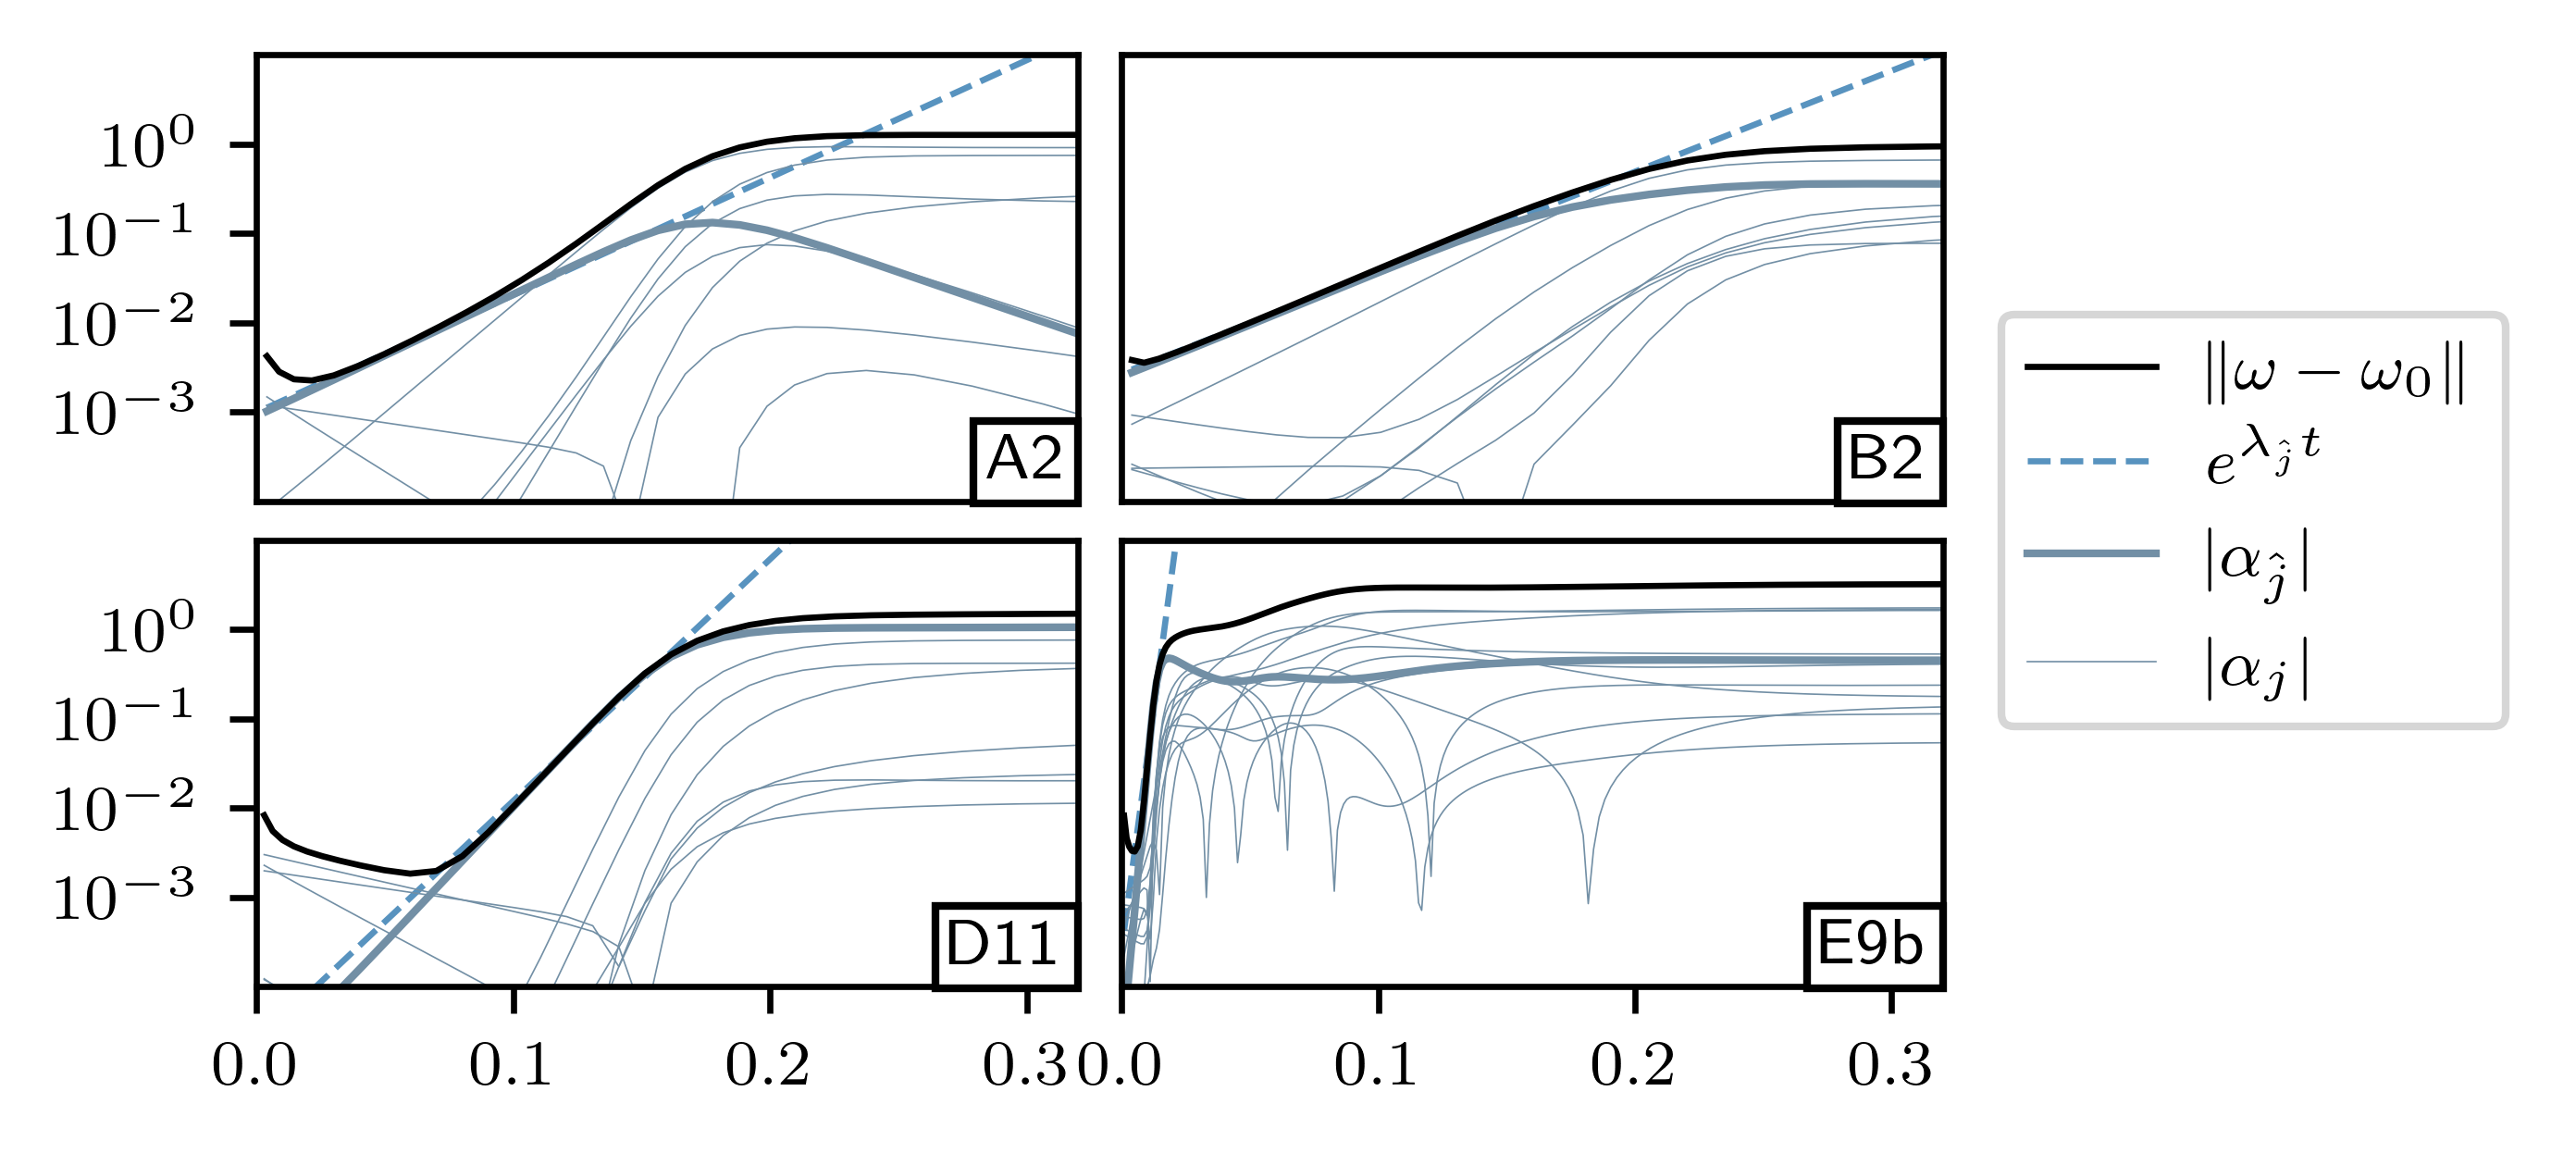

In [47]:
blu_scuro = np.r_[114, 143, 165, 255]/255
text_kw = dict(fontsize='small', ha='center', va='center')
bbox = dict(facecolor='white', boxstyle='square,pad=0.2', edgecolor='black')

def plot(ax, p, j_amp):
    ts = p.ts[1:]
    xs = p.xs[1:]
    norma = p.norma[1:]
    i_amp = np.argmin(np.abs( (np.abs(xs[:,j_amp]) - norma[:]) / norma ))
    ax.plot( ts, norma[i_amp] * np.exp( p.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='dashed', linewidth=0.8, c=blu, label=r'$e^{\lambda_{\hat{j}} t}$')
    for j in range(xs.shape[1]): 
        lab = r'$ \lvert \alpha_{\hat{j}} \rvert $' if j == j_amp else r'$ \lvert \alpha_j \rvert $' if j == xs.shape[1]-1 else ''
        ax.plot(ts, np.abs(xs[:,j]), linewidth=1 if j == j_amp else 0.2, c=blu_scuro, label=lab)
    ax.plot(ts, norma, linewidth=0.8, c='k', label=r'$ \Vert \omega - \omega_0 \Vert $')
    ax.set_yscale('log')

# fig = ply

fig = plt.figure(figsize=(linewidth, linewidth/2.2))
gs = fig.add_gridspec(2,3, width_ratios=[2, 2, 1.3])
axs = [ fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]) ]

ax = axs[0]
plot(ax, proj['A2'], 1)
ax.set_xlim(0, 0.32)
ax.set_ylim(1e-4, 1e1)
ax.xaxis.set_ticks([])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
ax.tick_params(axis='x', labelsize='small') 
ax.tick_params(axis='y', labelsize='small') 
ax.text(0.315, 1.33e-4, r'$\mathsf{A2}$', ha='right', va='bottom', bbox=bbox, fontsize='small')

ax = axs[1]
plot(ax, proj['B2'], 1)
ax.set_xlim(0, 0.32)
ax.set_ylim(1e-4, 1e1)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(axis='x', labelsize='small') 
ax.tick_params(axis='y', labelsize='small') 
ax.text(0.315, 1.33e-4, r'$\mathsf{B2}$', ha='right', va='bottom', bbox=bbox, fontsize='small')

ax = axs[2]
plot(ax, proj['D11'], 0)
ax.set_xlim(0, 0.32)
ax.set_ylim(1e-4, 1e1)
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
ax.tick_params(axis='x', labelsize='small') 
ax.tick_params(axis='y', labelsize='small') 
ax.text(0.315, 1.33e-4, r'$\mathsf{D11}$', ha='right', va='bottom', bbox=bbox, fontsize='small')

ax = axs[3]
plot(ax, proj['E9b'], 0)
ax.set_xlim(0, 0.32)
ax.set_ylim(1e-4, 1e1)
ax.yaxis.set_ticks([])
ax.tick_params(axis='x', labelsize='small') 
ax.tick_params(axis='y', labelsize='small') 
ax.text(0.315, 1.33e-4, r'$\mathsf{E9b}$', ha='right', va='bottom', bbox=bbox, fontsize='small')


lax = fig.add_subplot(gs[:,2])
lax.set_yticks([])
lax.axis('off')

s = [3, 0, 1, 2]
lax.legend([ axs[0].get_legend_handles_labels()[0][i] for i in s ], [ axs[0].get_legend_handles_labels()[1][i] for i in s ], loc='center', fontsize='small')

fig.tight_layout(h_pad=.5, w_pad=0)

fig.savefig('../immagini/ppproiezioni.pdf', **sf_kw)


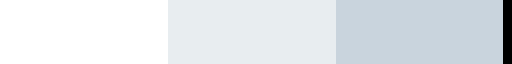

In [38]:
vals = np.repeat([ 0, 1, 2 ], 20)
vals = np.r_[ vals, 3 ]
colori = np.zeros(( vals.shape[0], 4 ))
colori[vals == 1] = np.r_[114, 143, 165, 40]/255
colori[vals == 2] = np.r_[114, 143, 165, 96]/255
colori[vals == 3] = np.r_[0, 0, 0, 255]/255
cmap = colors.ListedColormap(colori)
cmap

--------  --------  --------  --------  --------  --------  --------  --------
 1.00000   0.00000   0.00000  -0.00029   0.00000   0.00000  -0.00006   0.00000
 0.00000   1.00000   0.00017   0.00000  -0.00008   0.00000   0.00000  -0.00000
 0.00000   0.00017   1.00000  -0.00000  -0.00008  -0.00001  -0.00000   0.00000
-0.00029   0.00000  -0.00000   1.00000  -0.00000   0.00000   0.00004  -0.00000
 0.00000  -0.00008  -0.00008  -0.00000   1.00000   0.00013   0.00000  -0.00001
 0.00000   0.00000  -0.00001   0.00000   0.00013   1.00000   0.00000   0.00000
-0.00006   0.00000  -0.00000   0.00004   0.00000   0.00000   1.00000  -0.00000
 0.00000  -0.00000   0.00000  -0.00000  -0.00001   0.00000  -0.00000   1.00000
--------  --------  --------  --------  --------  --------  --------  --------


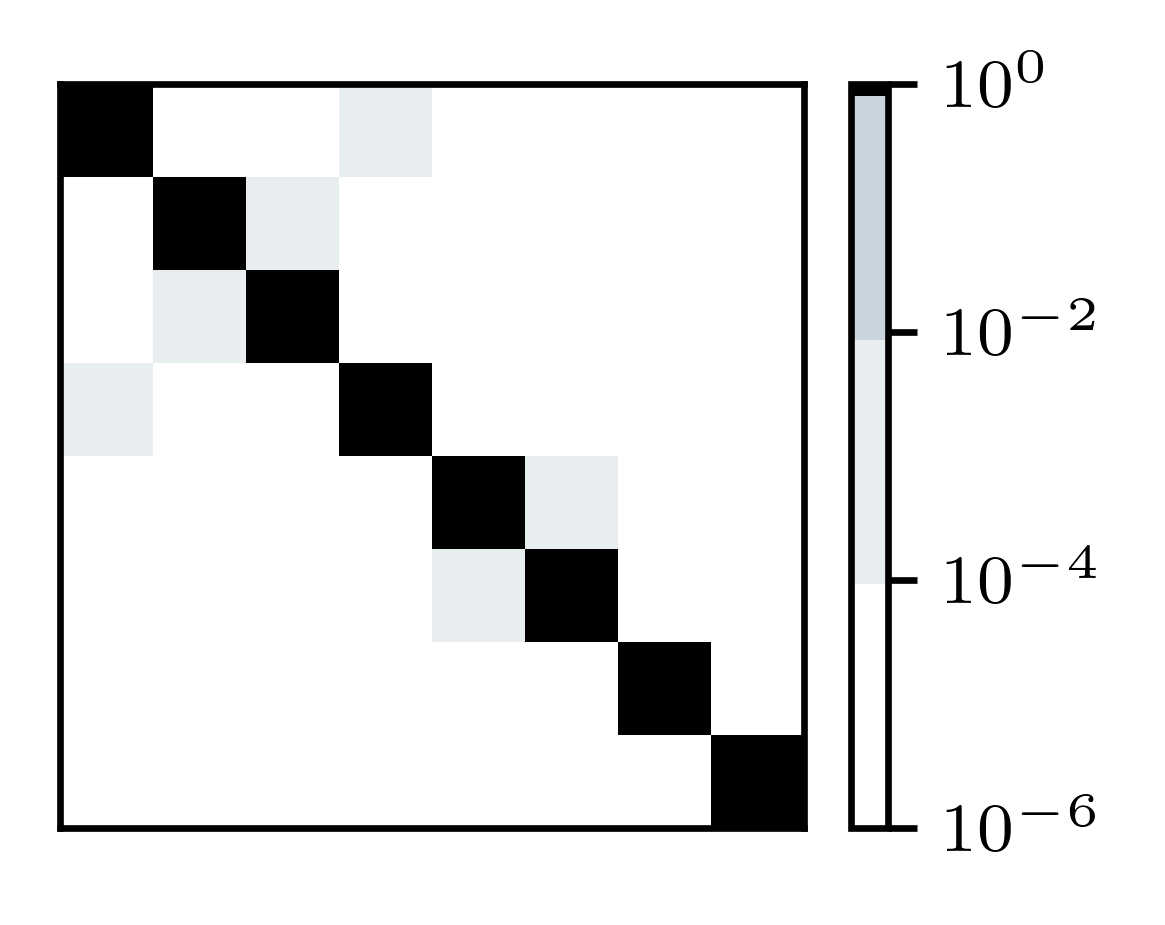

In [51]:
nome = 'D11'
res = proj[nome]
fig,ax = plt.subplots(subplot_kw=dict(xticks=[], yticks=[]), figsize=(0.3*linewidth, 0.24*linewidth))
im = ax.imshow(np.abs(res.ortho), norm=colors.LogNorm(vmin=1e-6, vmax=1), cmap=cmap)
fig.colorbar(im, ax=ax, ticks=[1, 1e-2, 1e-4, 1e-6])
# fig.savefig(f'../immagini/correlazioni_{nome}.png', **sf_kw)
print(tabulate(res.ortho, floatfmt='.5f'))

0.5875776397515529

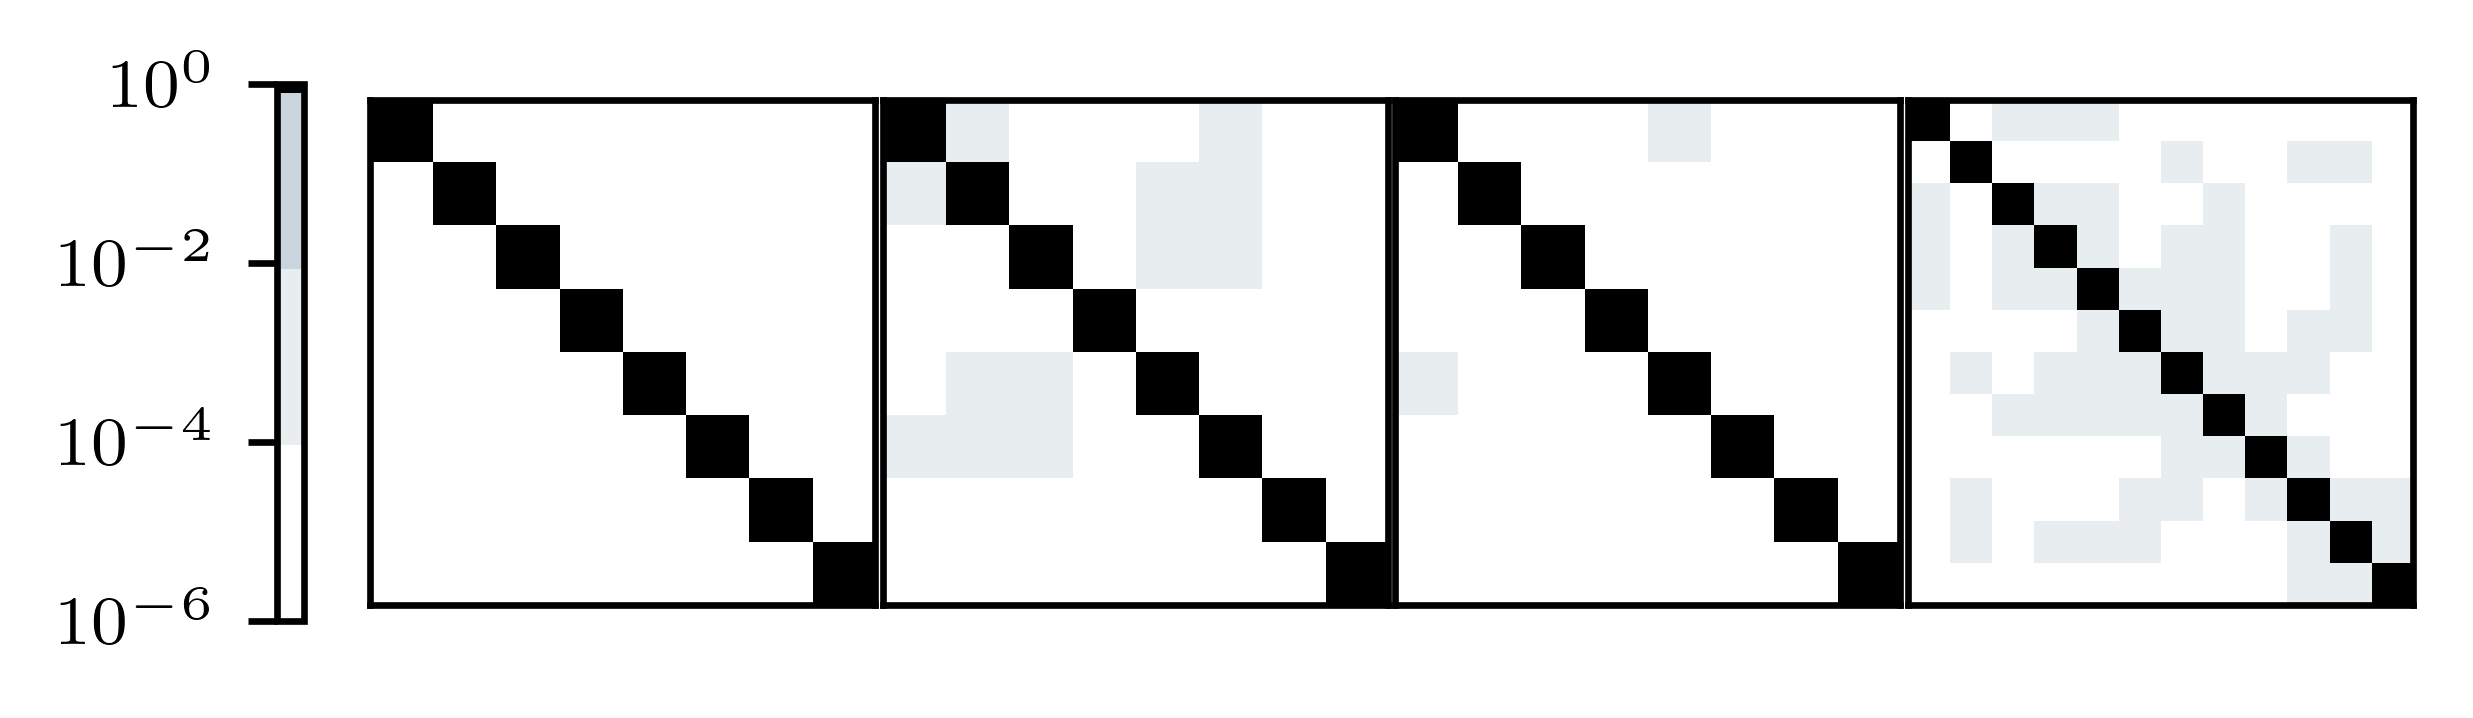

In [76]:
# print(tabulate(proj['E9b'].ortho, floatfmt='.5f')) 
# proj['E9b'].ortho[ np.abs(proj['E9b'].ortho) > 1e-3 ]

fig,axs = plt.subplots(1,4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(.55*linewidth, .55*linewidth/4))

im = axs[0].imshow(np.abs(proj['A2'].ortho), norm=colors.LogNorm(vmin=1e-6, vmax=1), cmap=cmap)
im = axs[1].imshow(np.abs(proj['B2'].ortho), norm=colors.LogNorm(vmin=1e-6, vmax=1), cmap=cmap)
im = axs[2].imshow(np.abs(proj['C2'].ortho), norm=colors.LogNorm(vmin=1e-6, vmax=1), cmap=cmap)
im = axs[3].imshow(np.abs(proj['E9b'].ortho), norm=colors.LogNorm(vmin=1e-6, vmax=1), cmap=cmap)

# for ax,nome in zip(axs, ['A2','B2','E9b']): ax.set_title(nome)

fig.tight_layout(pad=0.1)
# fig.colorbar(im, ax=ax, ticks=[1, 1e-2, 1e-4, 1e-6])
fig.colorbar(im, ax=axs, ticks=[1, 1e-2, 1e-4, 1e-6], fraction=0.04, pad=0.03, location='left')
fig.savefig(f'../immagini/correlazioni.png', **sf_kw)
im = Image.open(f'../immagini/correlazioni.png'); w,_ = im.size; w/600/linewidth

In [9]:
# def funs(nome):
#     res = proj[nome]
#     fig,axs = plt.subplots(3,4, figsize=(linewidth, linewidth/2/4*3))
    
#     for j,ax in enumerate(axs[1:,:].flatten()):
#         fun = res.eig.funs[:,j]
#         norm = np.linalg.norm(fun, np.inf)
#         plot_cells( res.pb, fun, ax=ax, cmap=cmap_dw, method='cubic', Nx=400, vmin=-norm, vmax=norm, fratture_lw=1 )
    
#     pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome=nome))
#     sD = pb.mdg.subdomains()[0]
#     dw = co.raccogli_stato(pb.mdg, 'concentrazione', sD) - pb._primo_steady_state[pb.dof[sD, 'concentrazione']]
#     plot_cells( pb, dw, ax=axs[0,0], cmap=cmap_dw, method='cubic', Nx=400, fratture_lw=1 )
    
#     axs[0,1].axis('off'); axs[0,2].axis('off'); axs[0,3].axis('off')
    
#     fig.tight_layout(pad=0.2)

# # funs('D11')
# # funs('A2')
# # funs('E9b')

In [10]:
# def evol(res, ax, i_f, xt, is_, i_amp, j_amp):    
#     ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
    
# #     ax.plot(ts, np.linalg.norm(xs, axis=1), linewidth=0.5, linestyle='dashed', c='k')
#     ax.plot(ts, norma, linewidth=0.5, linestyle='dashed', c='k')
#     ax.plot( ts, np.sign(res.xs[i_amp,j_amp])*norma[i_amp]*np.exp( res.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='solid', linewidth=0.3, c='lightgrey')
#     for i in range(xs.shape[1]): ax.plot(ts, xs[:,i], linewidth=0.4, c='k')
    
#     ax.xaxis.set_major_formatter('$ {x:.2f} $')
#     ax.yaxis.set_major_formatter('$ {x:.2f} $')
#     ax.tick_params(axis='both', which='major', labelsize='small')
    
#     return fig,ax

# def rate(nome, ax, i_dec, i_amp):
#     res = proj[nome]
#     ts = res.ts[1:]; norma = res.norma[1:]
#     ax.set_yscale('log')
# #     for val in res.eig.vals: 
# #         if val > 0: continue
# #         ax.plot( ts, norma[i_dec]*np.exp( val*(ts - ts[i_dec]) ), linestyle='dashed', linewidth=0.4, c='b' )
#     k = res.xs.shape[1]
#     for i in range(k): 
#         val = res.eig.vals[i]
# #         if val < 0: continue
#         ax.plot( ts, norma[i_amp]*np.exp( val*(ts - ts[i_amp]) ), linestyle='solid', linewidth=0.4, c='lightgrey')
#     ax.plot( ts, norma, c='k', linewidth=0.6, linestyle='dashed' )
#     ax.yaxis.tick_right()
# #     ax.set_yticks([])



Text(0.5, 0, '$t$')

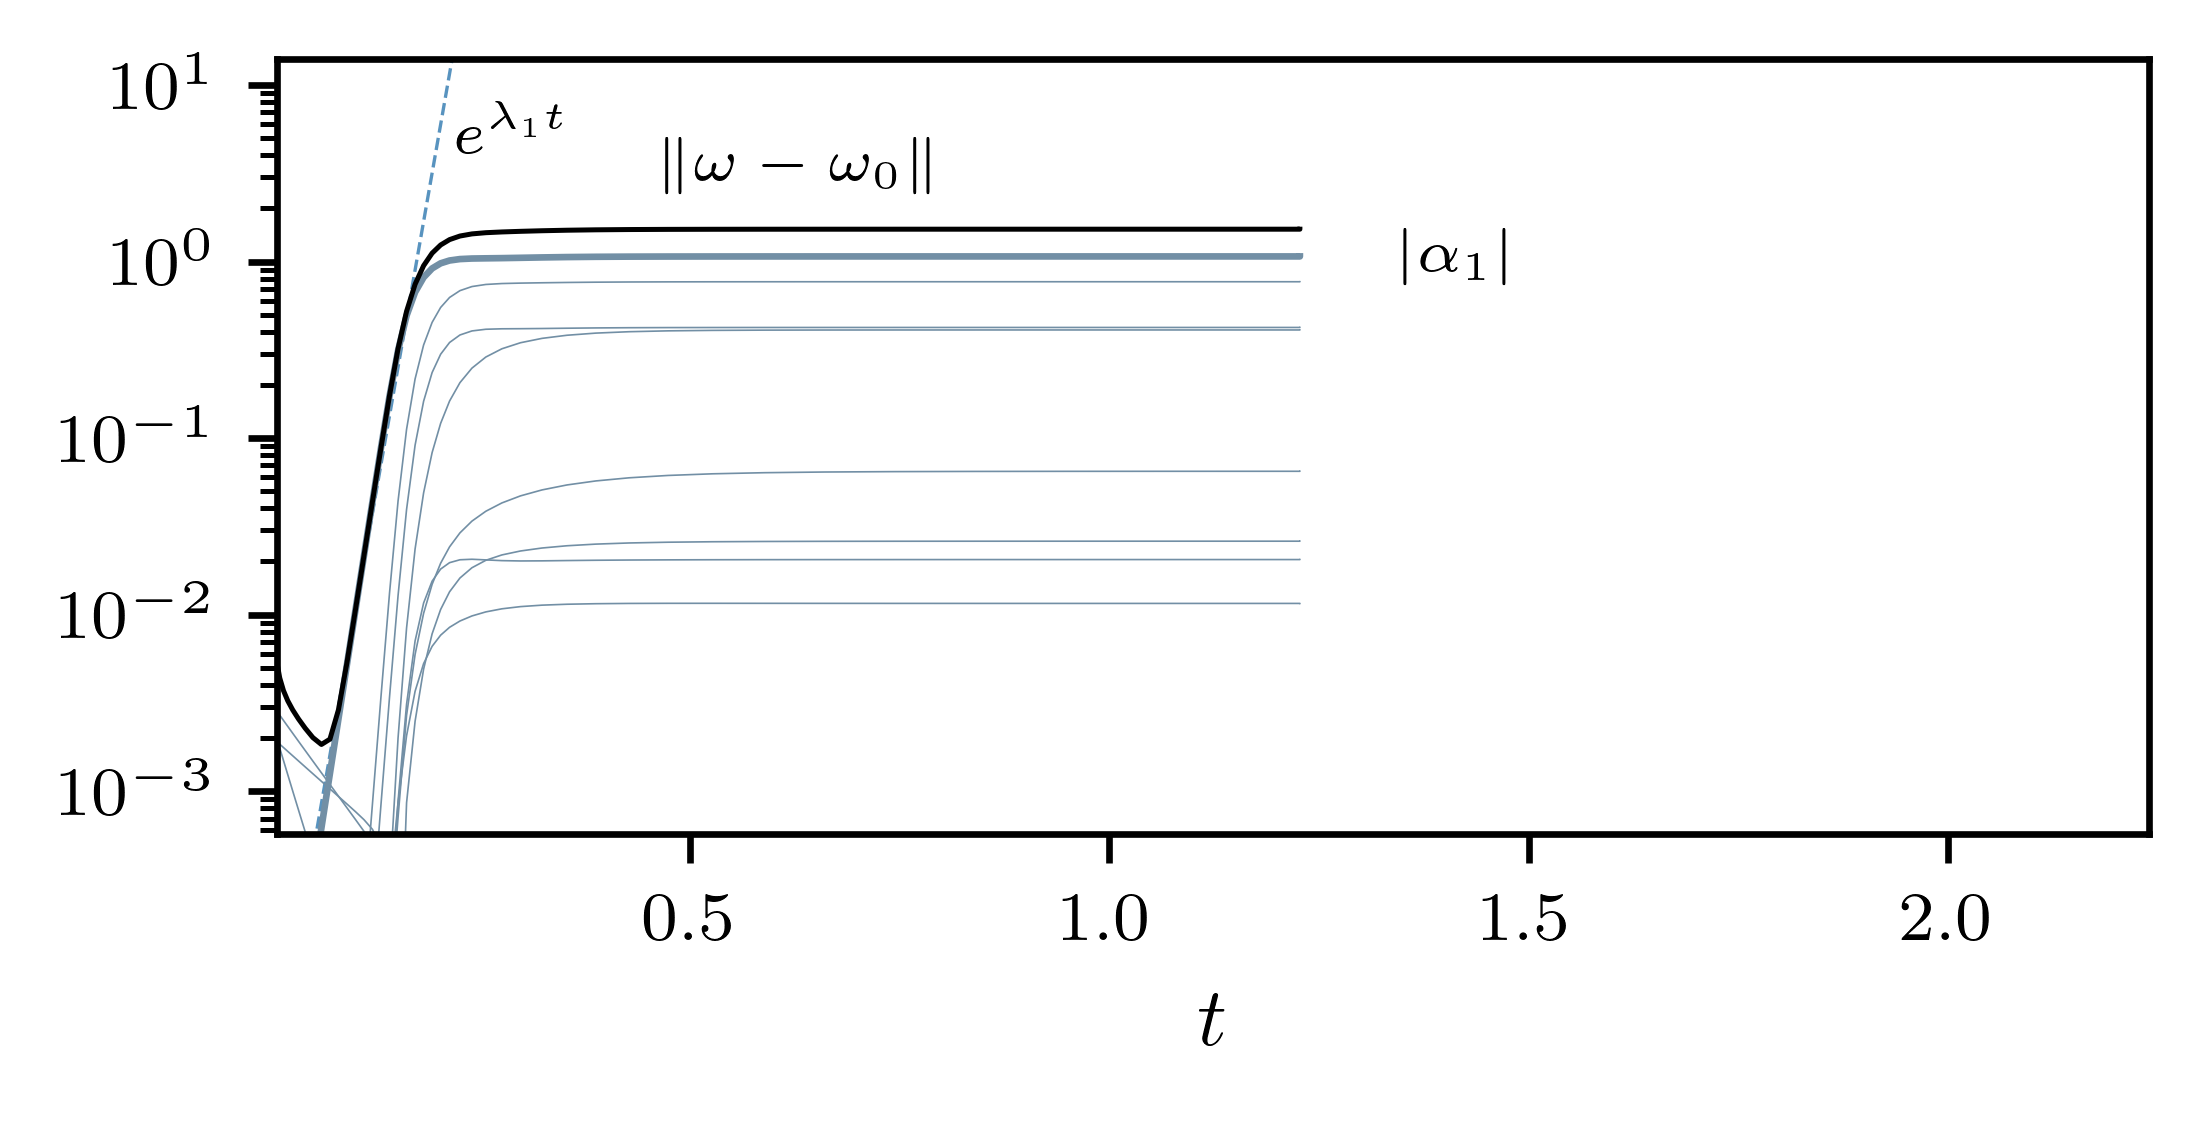

In [60]:
text_kw = dict(fontsize='x-small', ha='left', va='center')

def evoluzione(ax, res, i_f, j_amp, js):
    blu_scuro = np.r_[114, 143, 165, 255]/255

    ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
    i_amp = np.argmin(np.abs( np.abs(xs[1:,j_amp]) - norma[1:] ))

    # ax.scatter( ts[i_amp], norma[i_amp], s=100 )

#     s = 1.3
#     growth = norma[i_amp] * np.exp( res.eig.vals[j_amp]*np.c_[1/s, s].T * (ts - ts[i_amp]) )
#     ax.fill_between(ts, growth[0], growth[1], color='C0', alpha=0.05)

    ax.plot( ts, norma[i_amp] * np.exp( res.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='dashed', linewidth=0.4, c=blu, label=r'$ e^{\lambda_%d t}$' % j_amp )
    for j in range(xs.shape[1]):
        if j == j_amp: continue
        ax.plot(ts, np.abs(xs[:,j]), linewidth=0.2, c=blu_scuro)
    ax.plot(ts, np.abs(xs[:,j_amp]), linewidth=0.8, c=blu_scuro)
    ax.plot(ts, norma, linewidth=0.6, c='k', label=r'$ \Vert \omega - \omega_0 \Vert $')
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize='small')
    
    # ax.yaxis.set_ticks([])
    # ax.xaxis.set_ticklabels([])
    # ax.yaxis.set_ticklabels([])
    
    for j in js: ax.text(ts[-1]*1.1, np.abs(xs[-1,j]), r'$\lvert \alpha_%d \rvert$' % (j+1), **text_kw)
    
#     ax.legend(loc=2, prop= {'size': 'xx-small' })


fig,ax = plt.subplots(figsize=(linewidth*.6, linewidth*.25))
j_amp = 0
evoluzione(ax, proj['D11'], 1000, j_amp, [0])
ax.set_xlim(1e-2*1/1.4, 1.4*1.6)
ax.set_ylim(8e-4*1/1.4, 1e1*1.4)

ax.text(4.7e-1, 3.5e0, r'$ \Vert \omega - \omega_0 \Vert $', **text_kw)
ax.text(2.2e-1, 5e0, r'$e^{\lambda_%d t}$' % (j_amp+1), **text_kw)
ax.set_xlabel(r'$t$')

# fig.savefig(f'../immagini/ppproiezione_D11.png', **sf_kw)

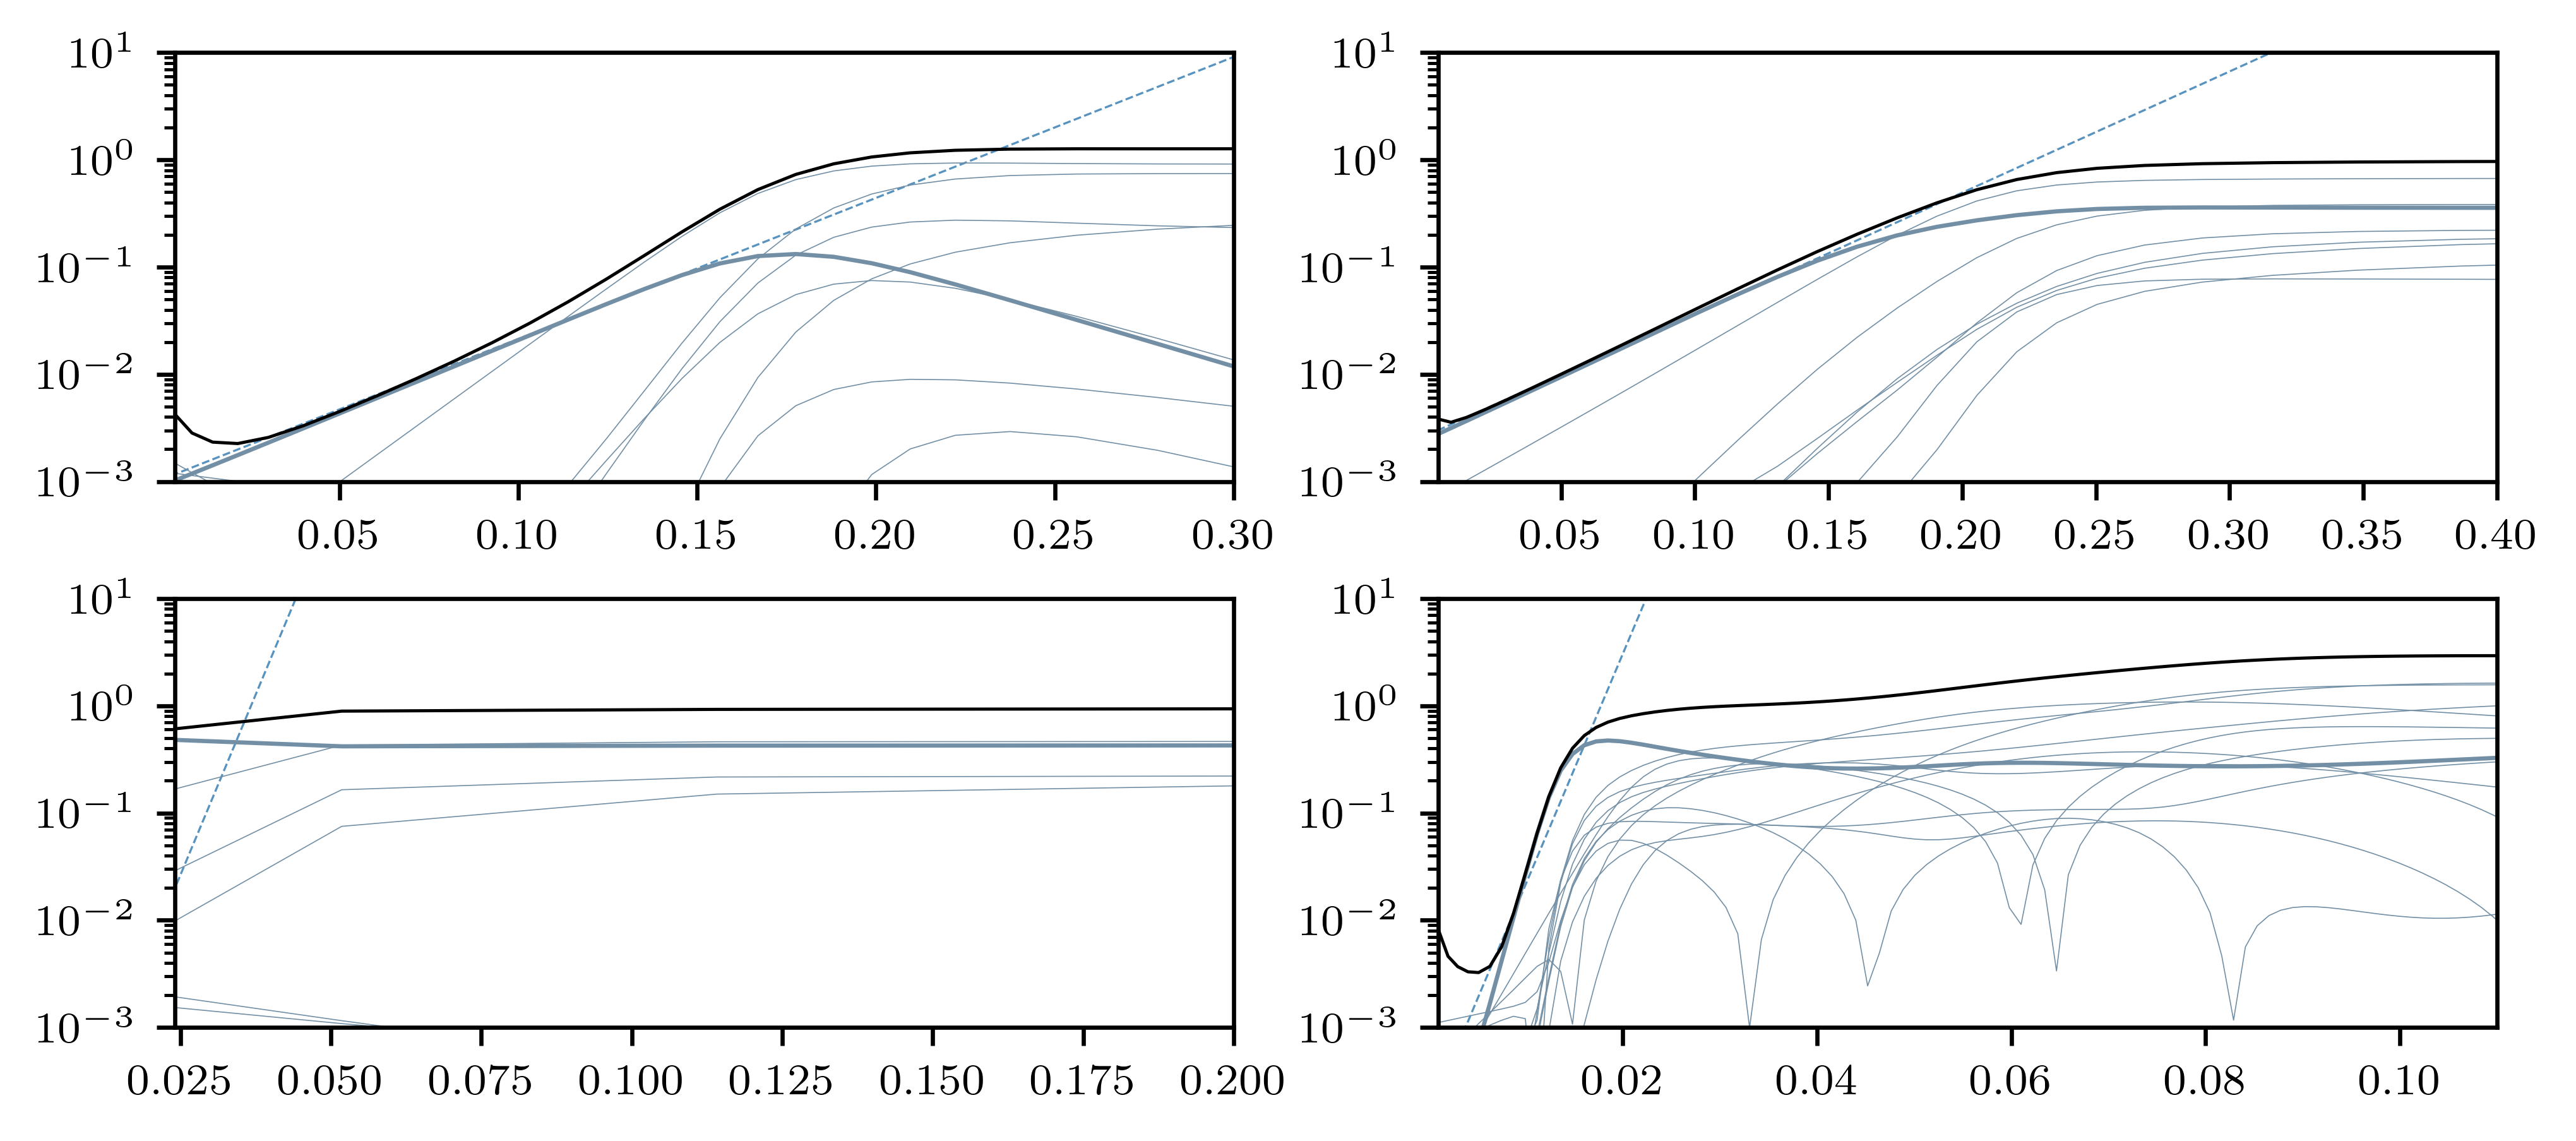

In [82]:
# fig = plt.figure(figsize=(linewidth, linewidth/2*2*0.44))
# gs = fig.add_gridspec(2,4)
# axs = [ fig.add_subplot(gs[0,0:2]), fig.add_subplot(gs[0,2:4]), fig.add_subplot(gs[1,1:3]) ]

fig,axs = plt.subplots(2,2,figsize=(linewidth, linewidth/2*2*0.44))
axs = axs.flatten()

text_kw = dict(fontsize='x-small', ha='left', va='center')


p = proj['A2']; ax = axs[0]
j_amp = 1
evoluzione(ax, p, -1, j_amp, [])
ax.set_xlim(p.ts[1], 0.3)
ax.set_ylim(1e-3, 1e1)
# ax.text(proj['A2'].ts[-1] + 0.03, proj['A2'].norma[-1] + 0.5, r'$ \Vert \omega - \omega_0 \Vert $', **text_kw|dict(va='bottom', ha='right'))
# ax.text(proj['A2'].ts[-1]*1.1, np.abs(proj['A2'].xs[-1,4]), r'$ \lvert \alpha_5 \rvert $', **text_kw)
# # ax.text(proj['A2'].ts[-1]*1.1, np.abs(proj['A2'].xs[-1,2]), r'$ \lvert \alpha_3 \rvert $', **text_kw)
# ax.text(proj['A2'].ts[39]*1.2, np.abs(proj['A2'].xs[39,1]), r'$ \lvert \alpha_2 \rvert $', **text_kw)
# ax.text(3.5e-1, 2e1, r'$ \! e^{\lambda_%d t}$' % (j_amp+1), **text_kw)
# ax.text(0.03, .94, 'A2', transform=ax.transAxes, va='top', ha='left')
# # ax.set_ylabel('A2', labelpad=10)
# ax.xaxis.set_ticklabels([])

p = proj['B2']; ax = axs[1]
j_amp = 1
evoluzione(ax, p, -1, j_amp, [])
ax.set_xlim(p.ts[1], 0.4)
ax.set_ylim(1e-3, 1e1)
# ax.text(proj['B2'].ts[-1] + 0.04, proj['B2'].norma[-1] + 0.5, r'$ \Vert \omega - \omega_0 \Vert $', **text_kw|dict(va='bottom', ha='right'))
# ax.text(1.8e-1, 5e0, r'$ \! e^{\lambda_%d t}$' % (j_amp+1), **text_kw)
# ax.text(0.03, .94, 'B2', transform=ax.transAxes, va='top', ha='left')
# ax.set_ylabel('B2', labelpad=17, rotation=-90)
ax.yaxis.set_label_position('right')

p = proj['C2']; ax = axs[2]
j_amp = 0
evoluzione(ax, p, -1, j_amp, [])
ax.set_xlim(p.ts[1], 0.2)
ax.set_ylim(1e-3, 1e1)
# ax.text(proj['B2'].ts[-1] + 0.04, proj['B2'].norma[-1] + 0.5, r'$ \Vert \omega - \omega_0 \Vert $', **text_kw|dict(va='bottom', ha='right'))
# ax.text(1.8e-1, 5e0, r'$ \! e^{\lambda_%d t}$' % (j_amp+1), **text_kw)
# ax.text(0.03, .94, 'B2', transform=ax.transAxes, va='top', ha='left')
# ax.set_ylabel('B2', labelpad=17, rotation=-90)
ax.yaxis.set_label_position('right')

p = proj['E9b']; ax = axs[3]
j_amp = 0
evoluzione(ax, p, 100, j_amp, [])
ax.set_xlim(p.ts[1], 0.11)
ax.set_ylim(1e-3, 1e1)
# ax.text(proj['E9b'].ts[100] + 0.005, proj['E9b'].norma[100] + 0.8, r'$ \Vert \omega - \omega_0 \Vert $', **text_kw|dict(va='bottom', ha='right'))
# ax.text(2.3e-2, 5e0, r'$ \! e^{\lambda_%d t}$' % (j_amp+1), **text_kw)
# ax.text(0.03, .94, 'E9b', transform=ax.transAxes, va='top', ha='left')
# ax.set_ylabel('E9b', labelpad=10)
# ax.set_xlabel(r'$t$')

# axs[3].set_axis_off()

# for ax in axs: 
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.set_xticks([], minor=1); ax.set_yticks([], minor=1)


# fig.constrained_layout(pad=0)
fig.tight_layout(pad=0.5)
# fig.savefig(f'../immagini/ppproiezioni.png', **sf_kw)

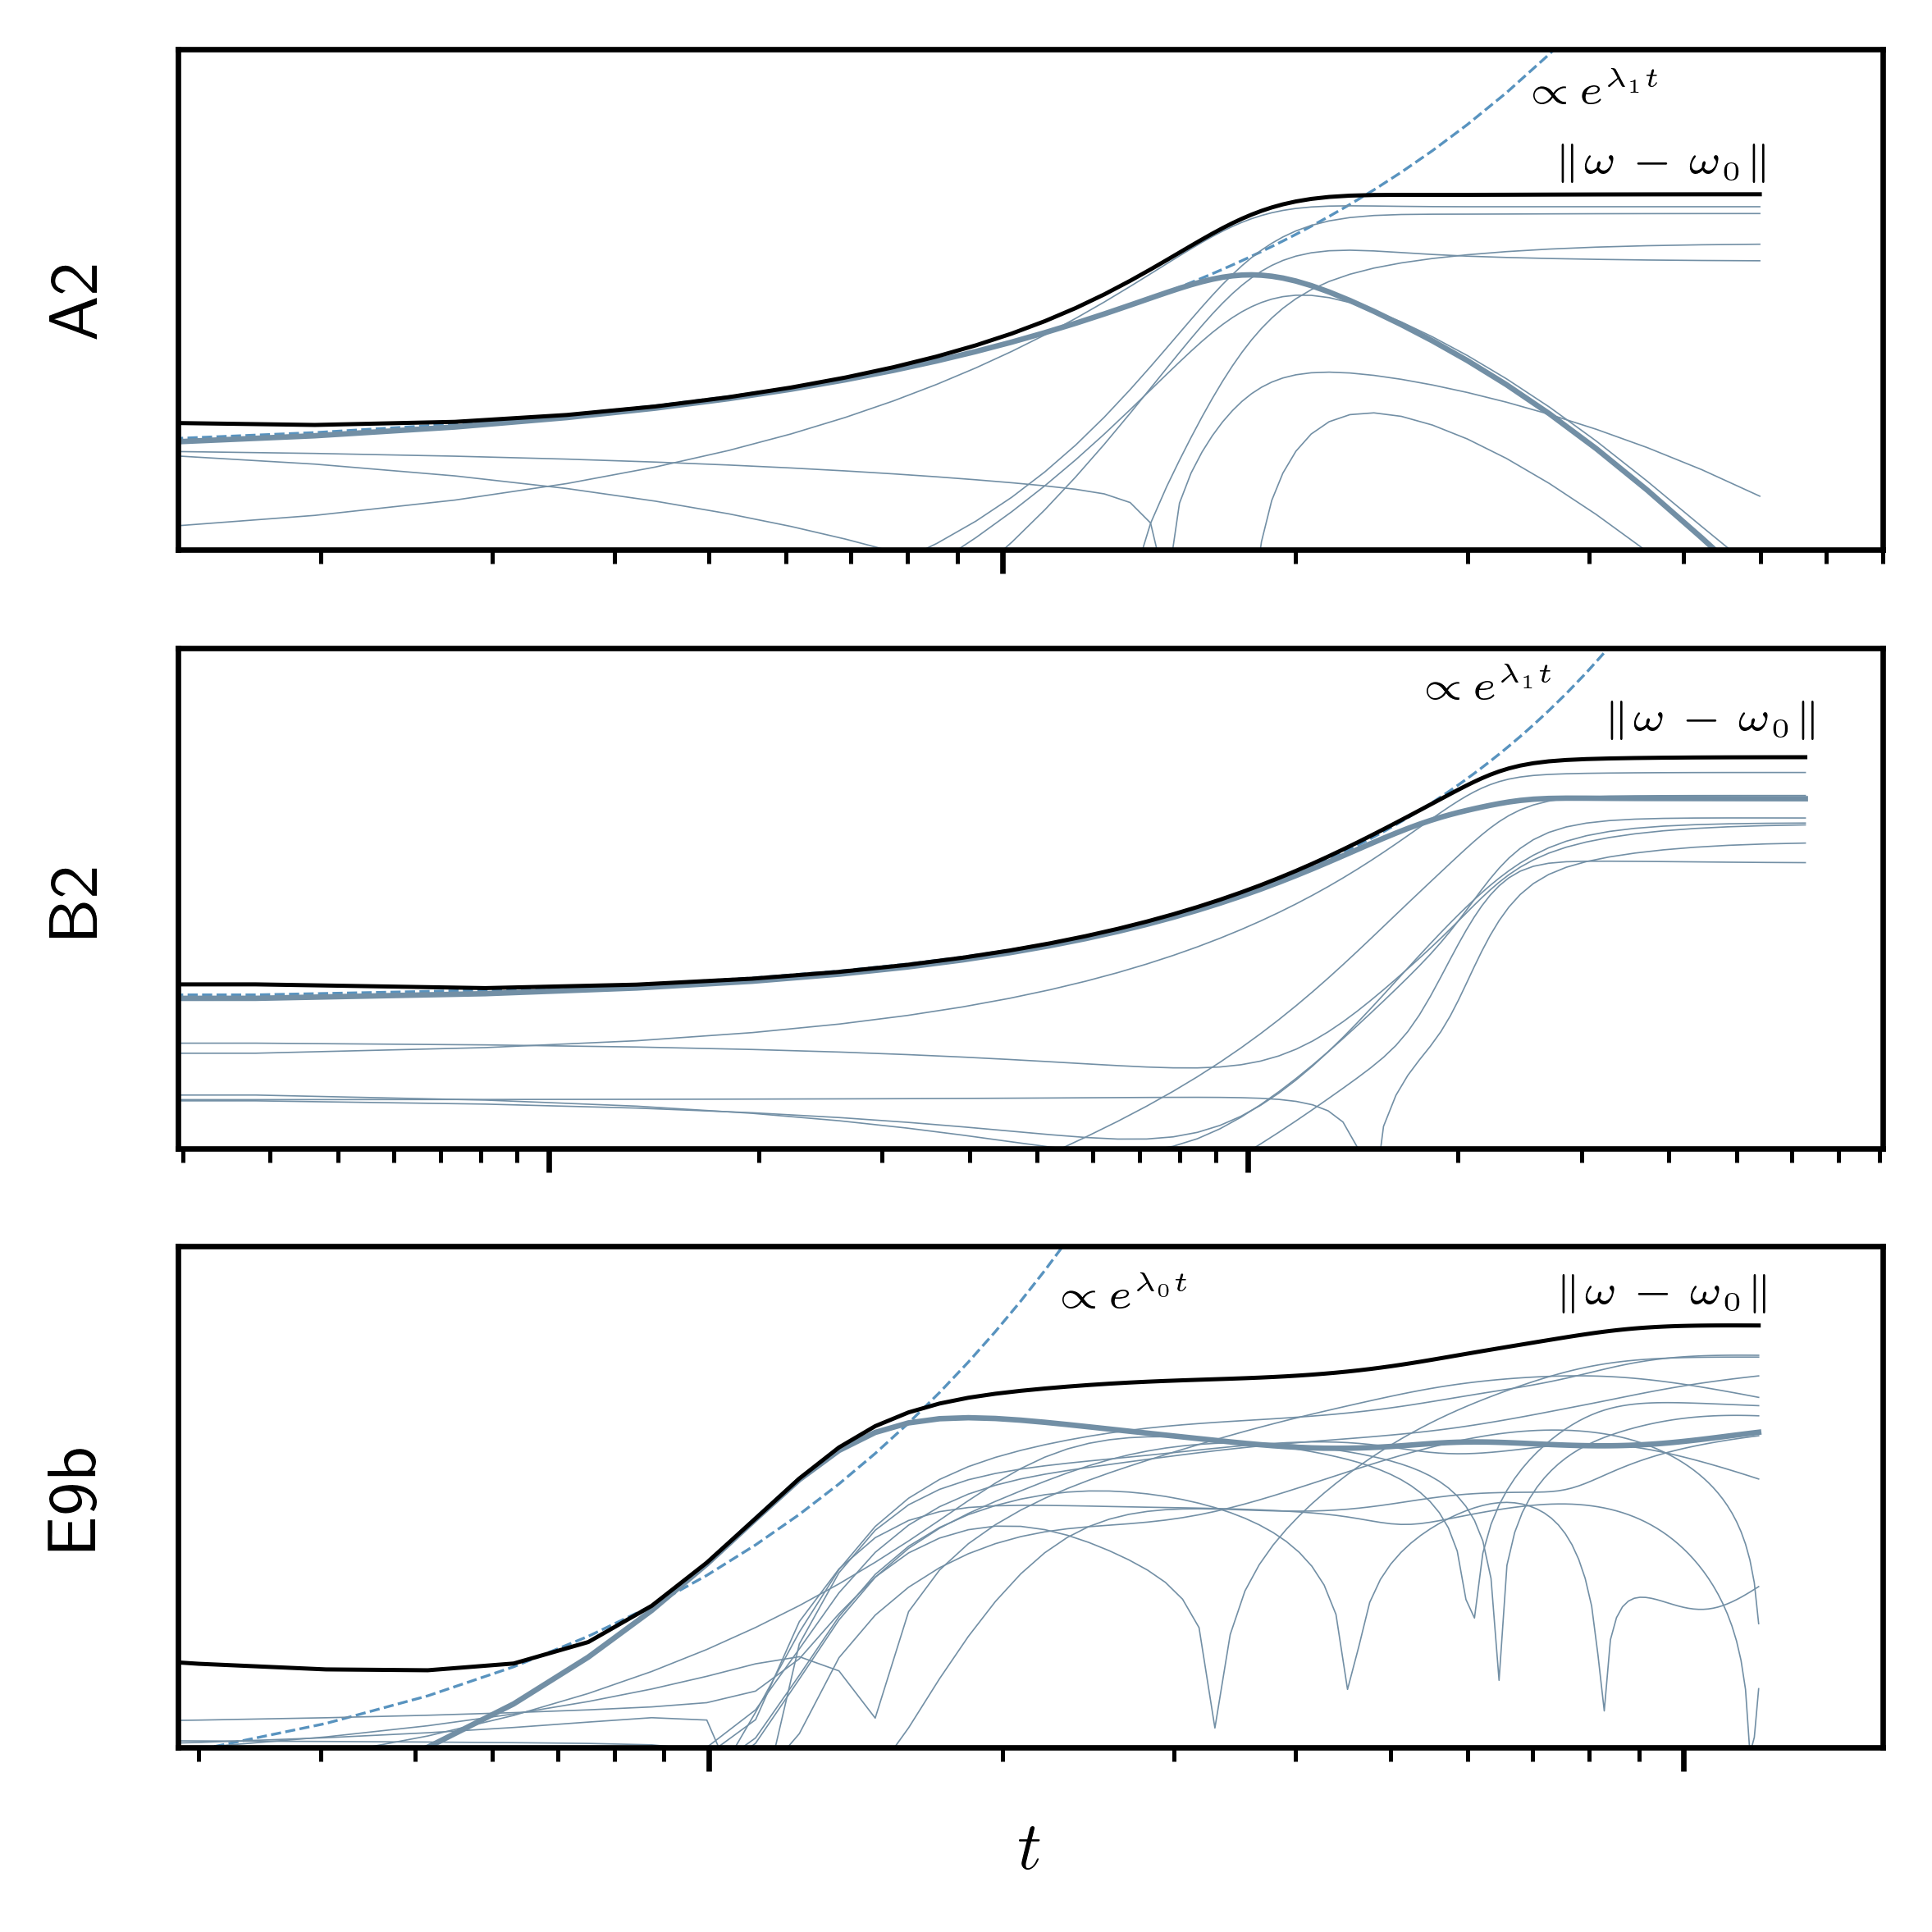

In [14]:
# fig,axs = plt.subplots(3,1,figsize=(linewidth*.6, linewidth*.2*3))

# ax = axs[0]
# j_amp = 1
# evoluzione(ax, proj['A2'], -1, j_amp, [])
# ax.set_xlim(2e-2*1/1.4, 5e-1*1.6)
# ax.set_ylim(1e-4*1/1.4, 5e1*1.4)
# text_kw = dict(fontsize='xx-small', ha='left', va='center')
# ax.text(3.74e-1, 3e0, '$ \Vert \omega - \omega_0 \Vert $', **text_kw)
# ax.text(3.5e-1, 2e1, '$\propto \! e^{\lambda_%d t}$' % j_amp, **text_kw)
# ax.set_ylabel('A2', labelpad=10)
# ax.xaxis.set_ticklabels([])


# ax = axs[1]
# j_amp = 1
# evoluzione(ax, proj['B2'], -1, j_amp, [])
# # ax.set_xlim(1e-2*1/1.4, ts[-1]*1.6)
# ax.set_ylim(1e-4*1/1.4, 1e1*1.4)
# text_kw = dict(fontsize='xx-small', ha='left', va='center')
# ax.text(3.3e-1, 2.4e0, '$ \Vert \omega - \omega_0 \Vert $', **text_kw)
# ax.text(1.8e-1, 5e0, '$\propto \! e^{\lambda_%d t}$' % j_amp, **text_kw)
# ax.set_ylabel('B2', labelpad=10)

# ax = axs[2]
# j_amp = 0
# evoluzione(ax, proj['E9b'], 100, j_amp, [])
# ax.set_xlim(4e-3*1/1.4, 1e-1*1.6)
# ax.set_ylim(1e-3*1/1.4, 1e1*1.4)
# # text_kw = dict(fontsize='xx-small', ha='left', va='center')
# ax.text(7.5e-2, 5.5e0, '$ \Vert \omega - \omega_0 \Vert $', **text_kw)
# ax.text(2.3e-2, 5e0, '$\propto \! e^{\lambda_%d t}$' % j_amp, **text_kw)
# ax.set_ylabel('E9b', labelpad=10)
# ax.set_xlabel('$t$')

# fig.tight_layout()
# fig.savefig(f'../immagini/pproiezioni.png', **sf_kw)

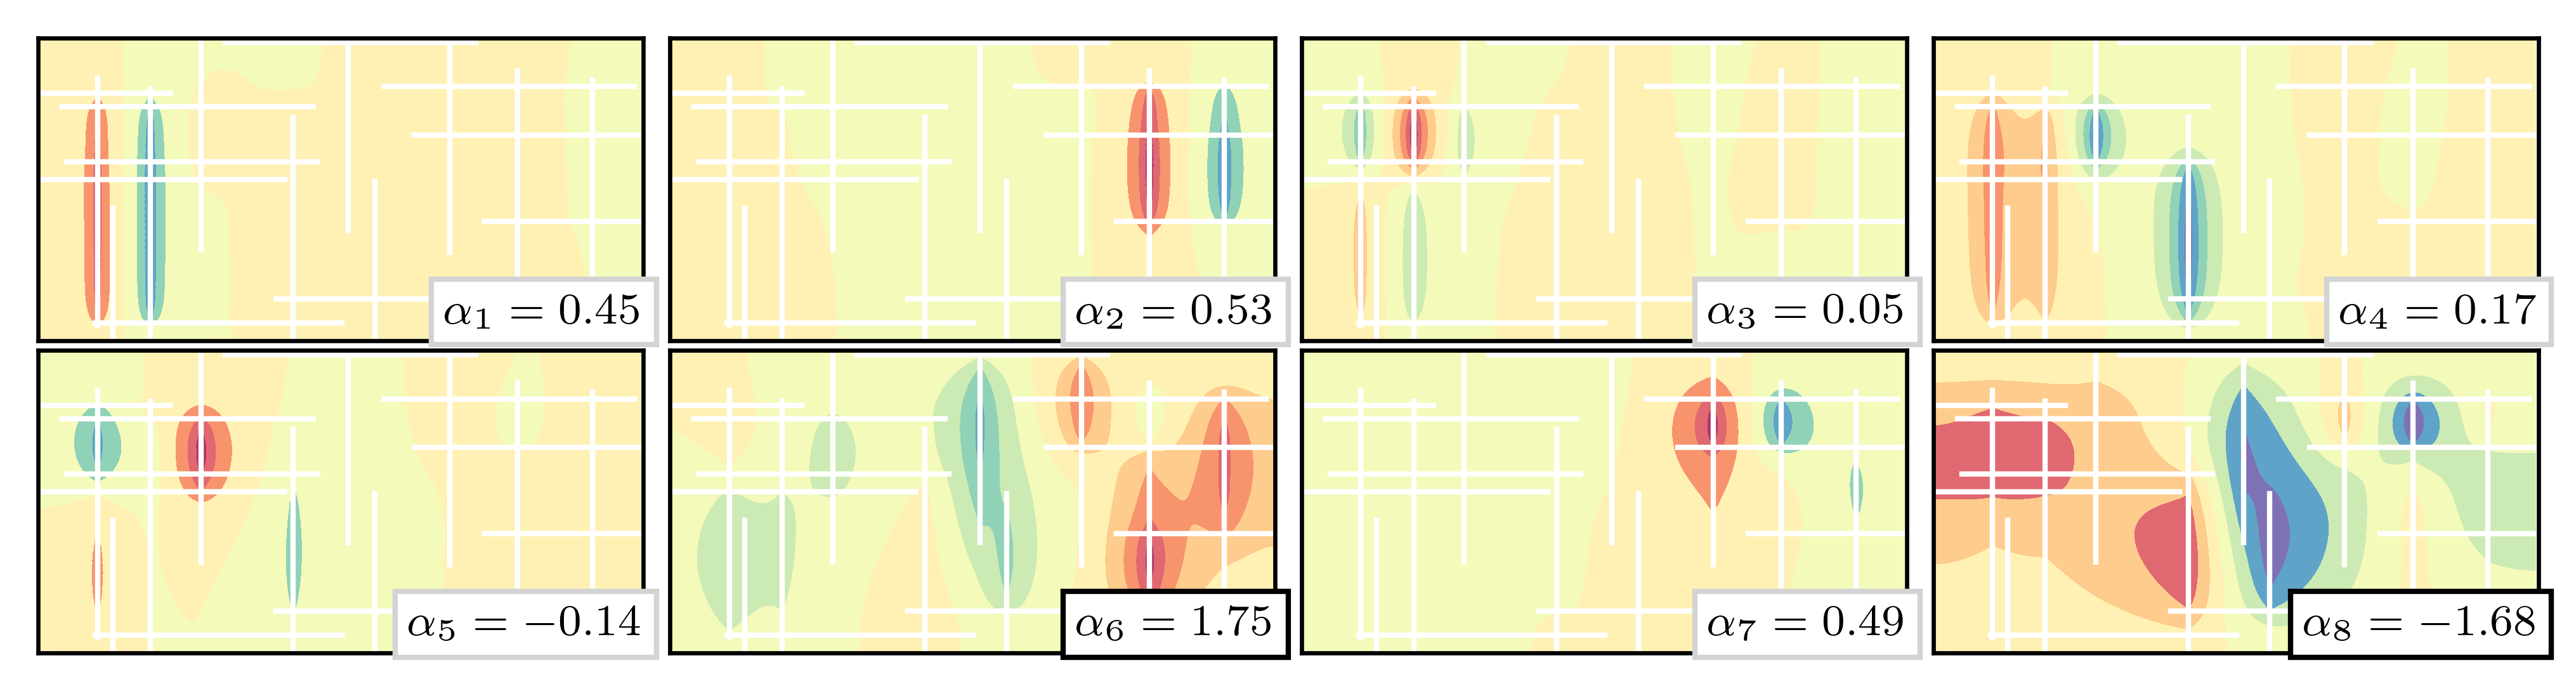

In [15]:
nome = 'E9b'
res = proj[nome]

fig,axs = plt.subplots(2,4, figsize=(linewidth, linewidth/4/2*2*1.05))
axsf = axs.flatten()
for j,ax in enumerate(axsf):
    fun = res.eig.funs[:,j]
    norm = np.linalg.norm(fun, np.inf)
    plot_cells( res.pb, fun, ax=ax, cmap=cmap_dw, method='cubic', Nx=512, vmin=-norm, vmax=norm, fratture_lw=1 )
    alpha = res.xs[-1,j]
    bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='lightgrey' if abs(alpha) < 1 else 'black')
    ax.text(20, 0.3, r'$ \alpha_{%d} = %.2f $' % (j+1, alpha) , ha='right', va='bottom', bbox=bbox, fontsize='small')

fig.tight_layout(pad=0.5)
fig.savefig(f'../immagini/proiezione_E9b.png', **sf_kw)

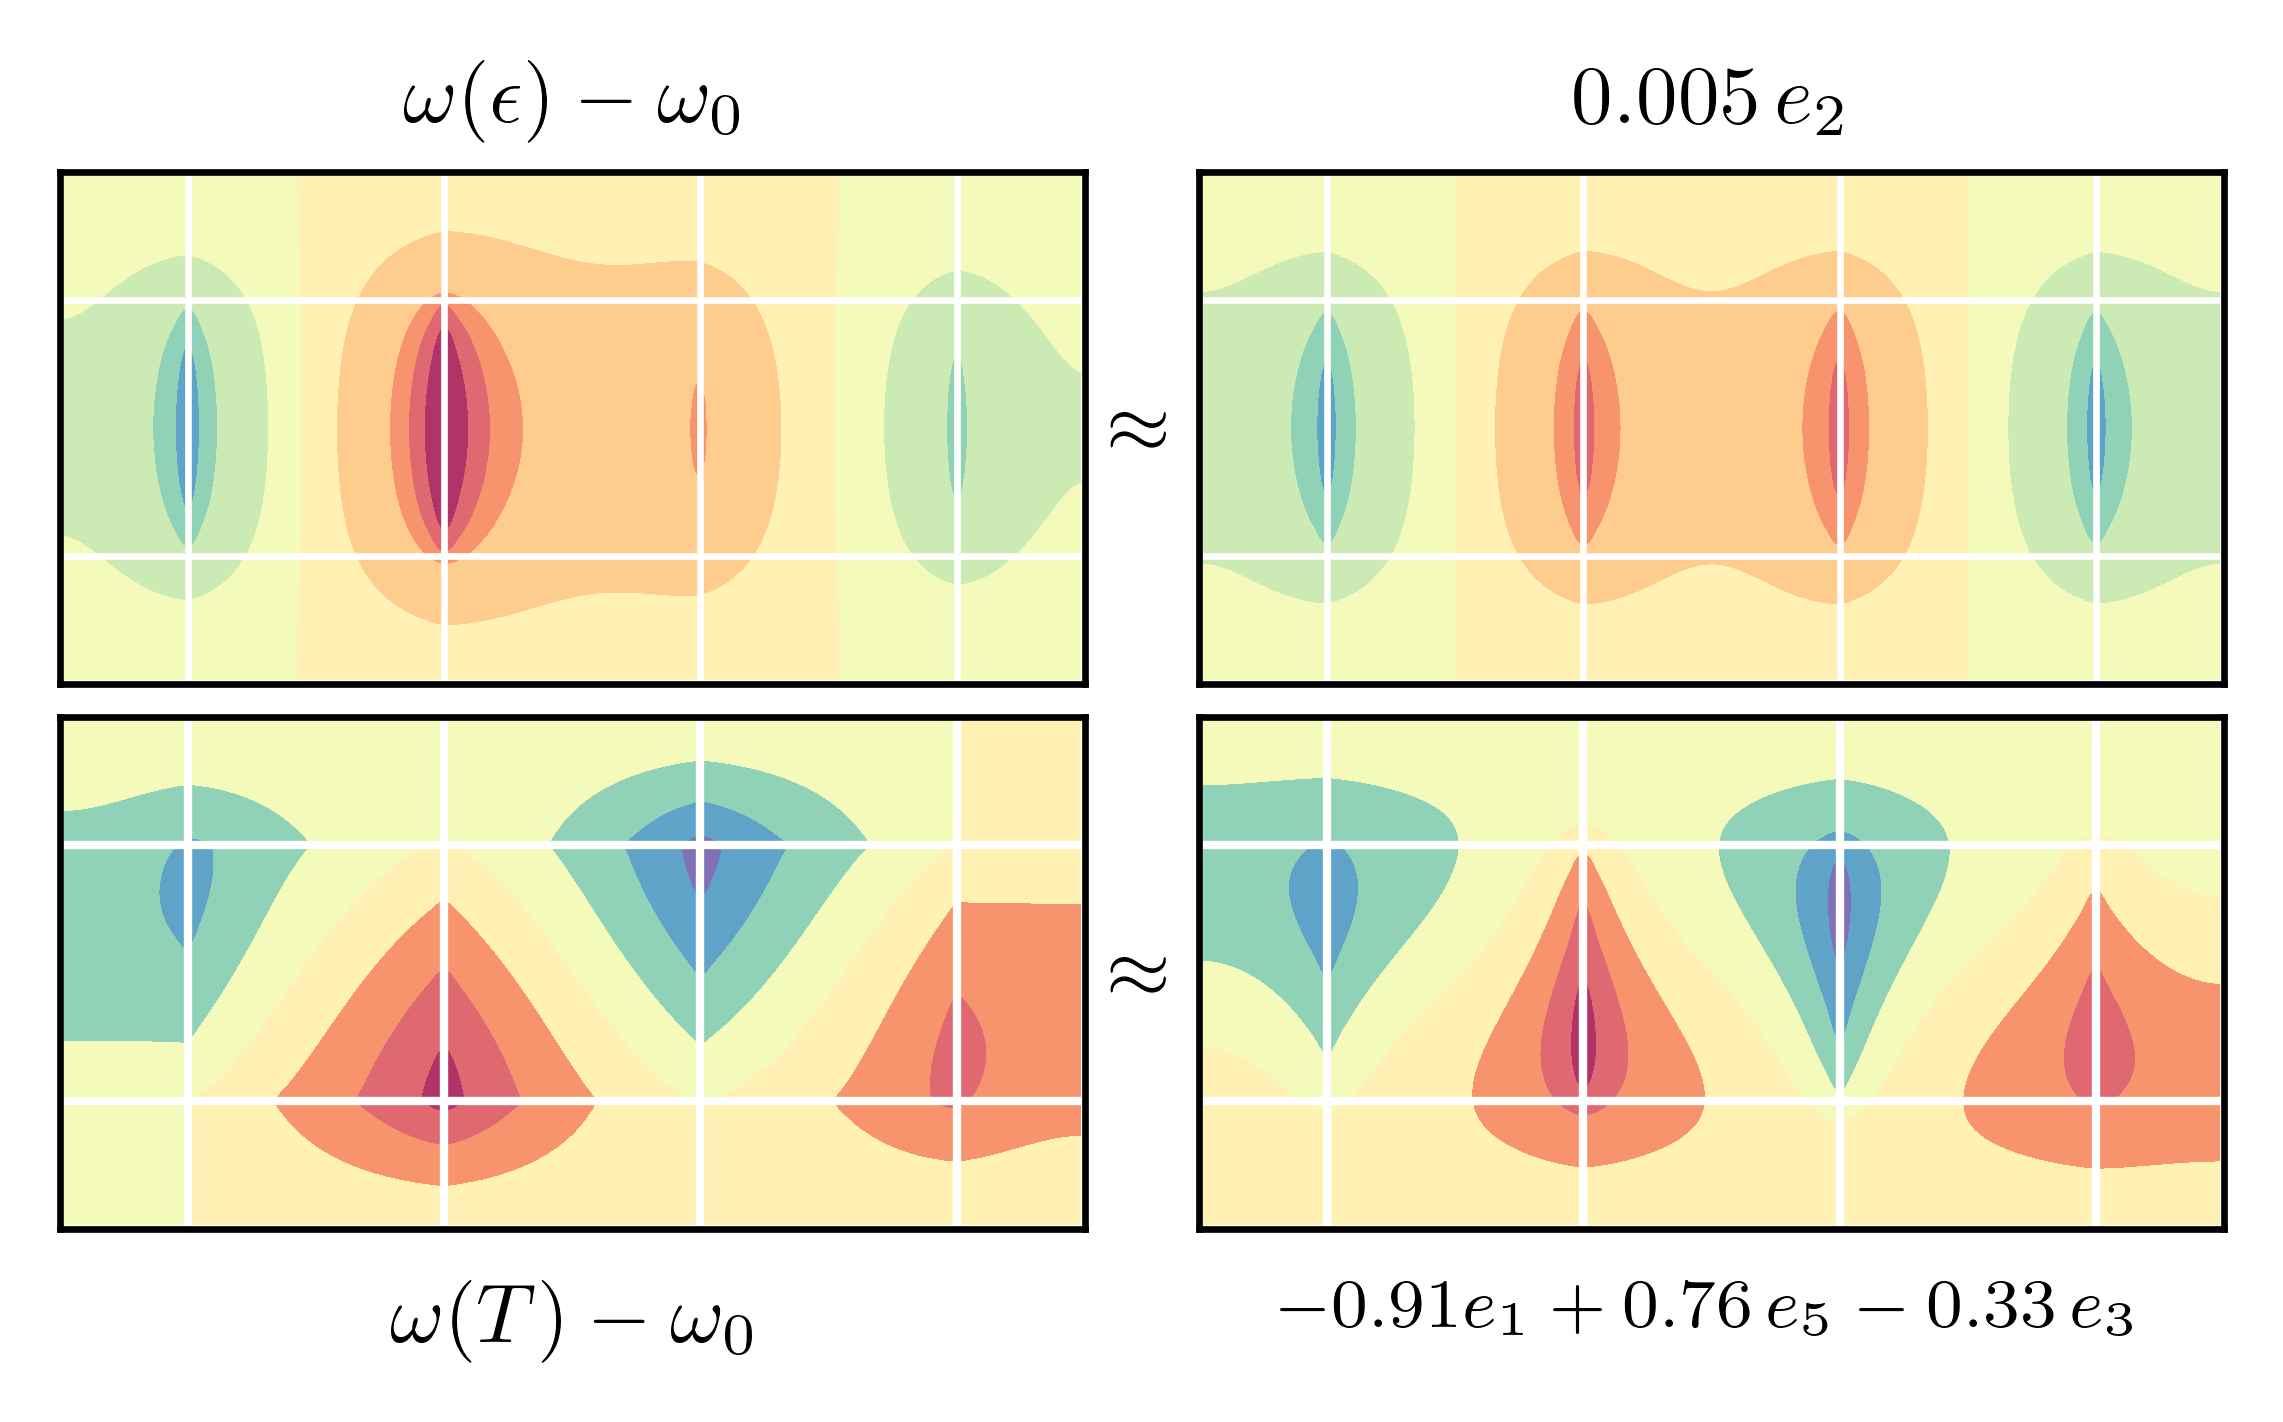

In [75]:
fig,axs = plt.subplots(2,3, figsize=(.55*linewidth, .64*linewidth/2/2*2), width_ratios=[1, 0, 1])

nome = 'A2'
pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome=nome))
res = proj[nome]
i_inf = 47; i_eps = 8

js = [1]
dw_eps = pb.importa_i(pb.vtu_is[i_eps])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
eig_eps = sum([res.xs[i_eps,j]*res.eig.funs[:,j] for j in js])

lp = 6
vm = np.linalg.norm(dw_eps, np.inf); 
kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm, fratture_lw=.8, levels=10)

plot_cells(pb, dw_eps, ax=axs[0,0], **kw)
axs[0,0].set_xlabel(r'$ \omega(\epsilon)-\omega_0 $', labelpad=lp)
axs[0,0].xaxis.set_label_position('top') 

axs[0,1].text(0.5, 0.5, r'$ \approx $', va='center', ha='center')
axs[0,1].set_axis_off()

plot_cells(res.pb, eig_eps, ax=axs[0,2], **kw)
axs[0,2].set_xlabel(r'$ %.3f\,e_%d $' % (norma_eig_eps,js[0]+1), labelpad=lp)
axs[0,2].xaxis.set_label_position('top') 


js = [0,4,2]
dw_inf = pb.importa_i(pb.vtu_is[i_inf])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
eig_inf = sum([res.xs[i_inf,j]*res.eig.funs[:,j] for j in js])

vm = np.linalg.norm(dw_inf,np.inf); kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm, fratture_lw=1)
plot_cells(pb, dw_inf, ax=axs[1,0], **kw)
axs[1,0].set_xlabel(r'$ \omega(T) - \omega_0 $', labelpad=lp)

axs[1,1].text(0.5, 0.5, r'$ \approx $', va='center', ha='center')
axs[1,1].set_axis_off()

plot_cells(res.pb, eig_inf, ax=axs[1,2], **kw)
axs[1,2].set_xlabel(f'$ {res.xs[i_inf,js[0]]:.2f} e_{js[0]+1} ' + ''.join([ f'{res.xs[i_inf,j]:+.2f} \, e_{j+1}' for j in js[1:] ]) + ' $', fontsize='small', labelpad=lp)

fig.tight_layout(pad=0.3)
fig.savefig(f'../immagini/proiezione_A2.png', **sf_kw)

In [ ]:
raise

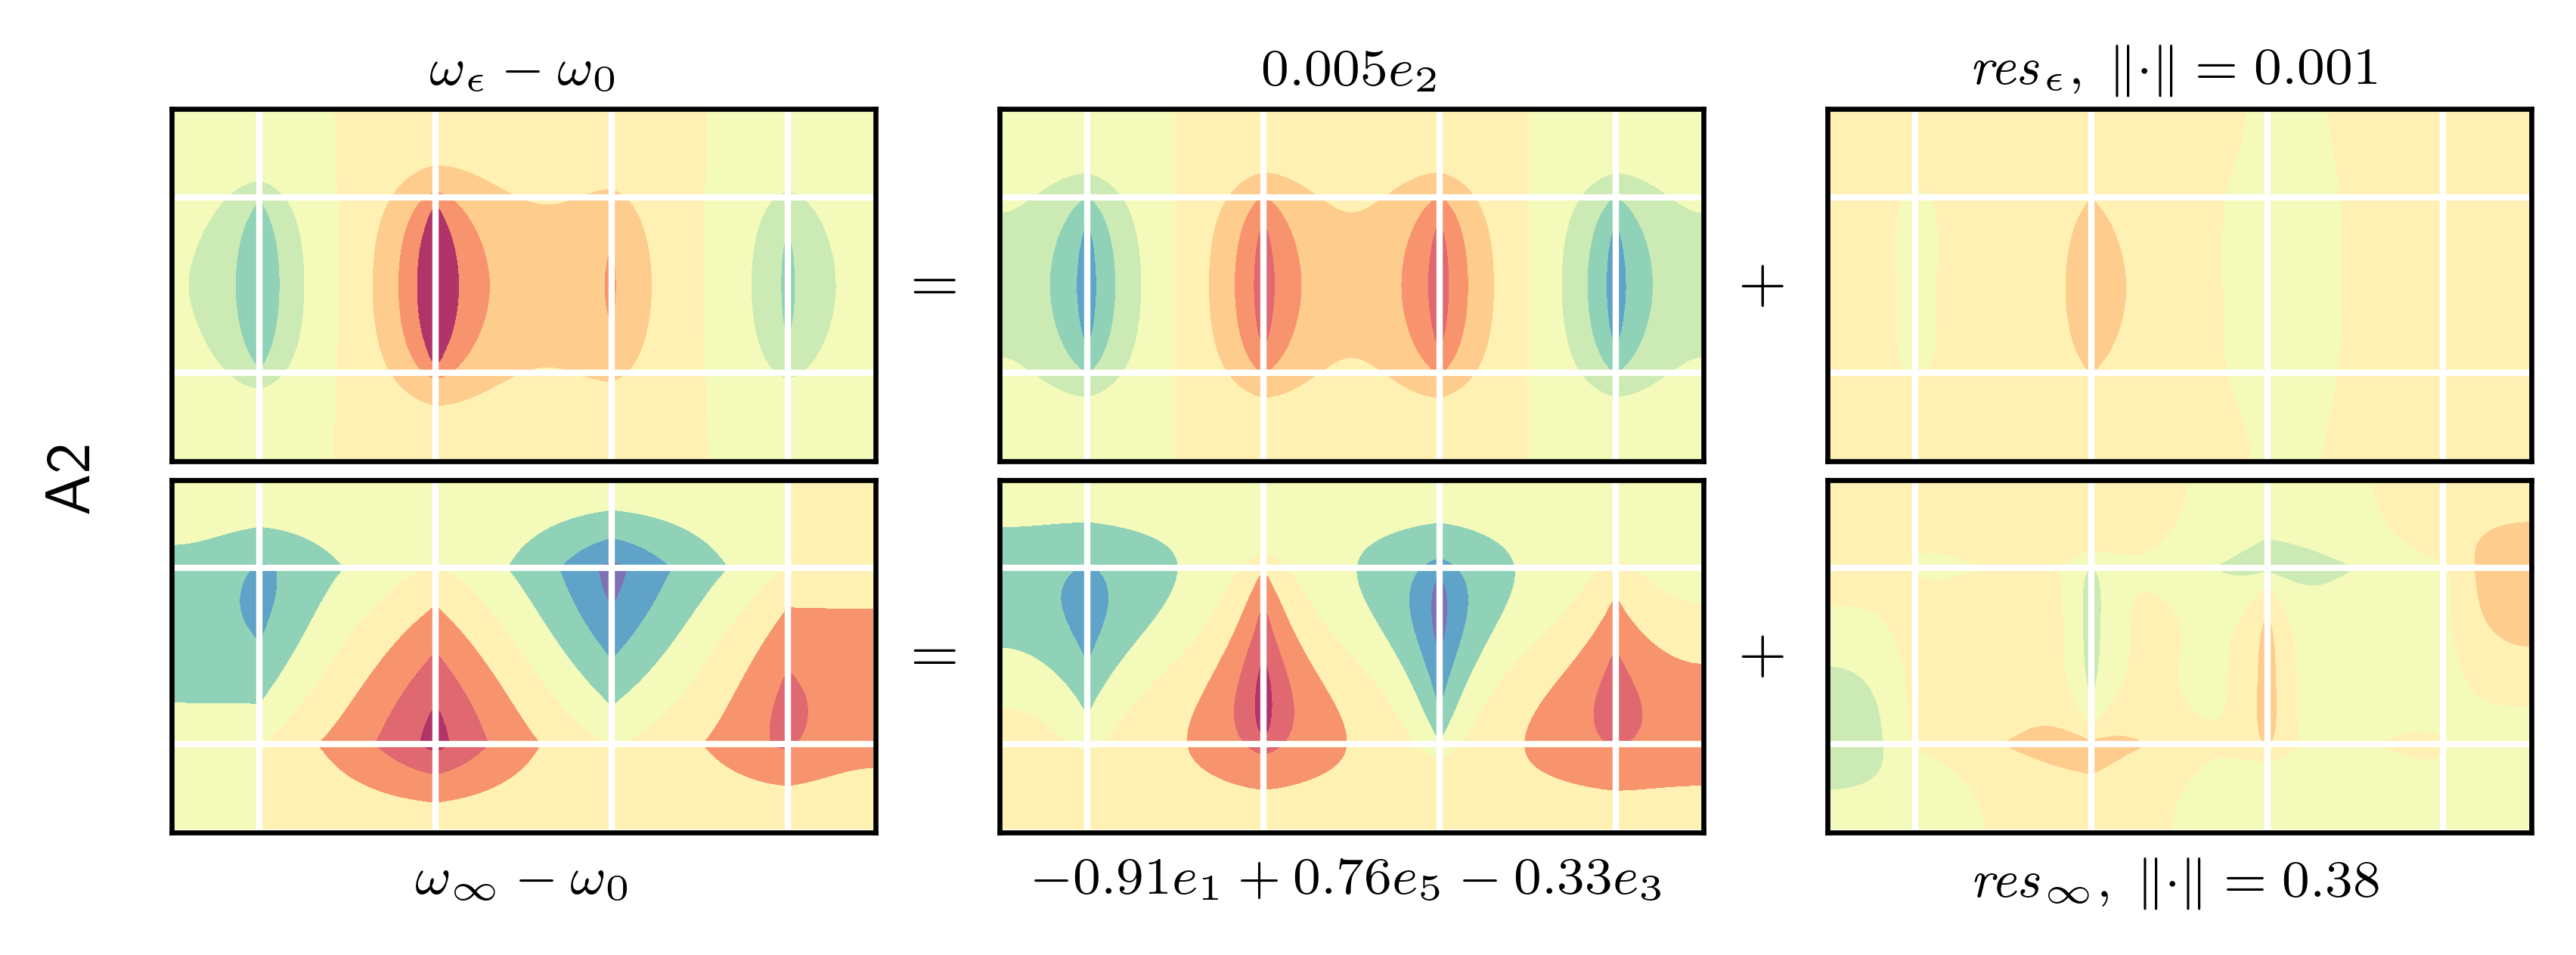

In [60]:
fig,axs = plt.subplots(2,5, figsize=(.8*linewidth, .8*linewidth/2/2.8*2), width_ratios=[1, 0, 1, 0, 1])

nome = 'A2'; i_inf = 47; i_eps = 8

pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome=nome))
res = proj[nome]; sD = pb.mdg.subdomains()[0]

js = [1]
dw_eps = pb.importa_i(pb.vtu_is[i_eps])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
eig_eps = sum([res.xs[i_eps,j]*res.eig.funs[:,j] for j in js])
residuale_eps = dw_eps - eig_eps
norma_eig_eps = np.sqrt(np.dot(eig_eps, pb._M@eig_eps))
norma_residuale_eps = np.sqrt(np.dot(residuale_eps, pb._M@residuale_eps))

vm = np.linalg.norm(dw_eps,np.inf); kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm, fratture_lw=1, method='cubic', Nx=512)
plot_cells(pb, dw_eps, ax=axs[0,0], **kw)
axs[0,0].set_xlabel(f'$ \\omega_\\epsilon-\\omega_0 $', fontsize='small')
axs[0,0].xaxis.set_label_position('top') 
axs[0,1].text(0.5, 0.5, f'$ = $', va='center', ha='center')
axs[0,1].set_axis_off()
plot_cells(res.pb, eig_eps, ax=axs[0,2], **kw)
axs[0,2].set_xlabel(f'$ {norma_eig_eps:.3f} e_{js[0]+1} $', fontsize='small')
axs[0,2].xaxis.set_label_position('top') 
axs[0,3].text(0.5, 0.5, f'$ + $', va='center', ha='center')
axs[0,3].set_axis_off()
plot_cells(res.pb, residuale_eps, ax=axs[0,4], **kw)
axs[0,4].set_xlabel(r'$ \mathit{res}_\epsilon,\;\lVert\cdot\rVert = %.3f $' % norma_residuale_eps, fontsize='small')
axs[0,4].xaxis.set_label_position('top') 


js = [0,4,2]
dw_inf = pb.importa_i(pb.vtu_is[i_inf])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
eig_inf = sum([res.xs[i_inf,j]*res.eig.funs[:,j] for j in js])
residuale_inf = dw_inf - eig_inf
norma_eig_inf = np.sqrt(np.dot(eig_inf, pb._M@eig_inf))
norma_residuale_inf = np.sqrt(np.dot(residuale_inf, pb._M@residuale_inf))

vm = np.linalg.norm(dw_inf,np.inf); kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm, fratture_lw=1, method='cubic', Nx=512)
plot_cells(pb, dw_inf, ax=axs[1,0], **kw)
axs[1,0].set_xlabel(f'$ \\omega_\\infty-\\omega_0 $', fontsize='small')
axs[1,1].text(0.5, 0.5, f'$ = $', va='center', ha='center')
axs[1,1].set_axis_off()
plot_cells(res.pb, eig_inf, ax=axs[1,2], **kw)
axs[1,2].set_xlabel(f'$ {res.xs[i_inf,js[0]]:.2f} e_{js[0]+1} ' + ''.join([ f'{res.xs[i_inf,j]:+.2f} e_{j+1}' for j in js[1:] ]) + ' $', fontsize='small')
axs[1,3].text(0.5, 0.5, f'$ + $', va='center', ha='center')
axs[1,3].set_axis_off()
plot_cells(res.pb, residuale_inf, ax=axs[1,4], **kw)
axs[1,4].set_xlabel(r'$ \mathit{res}_\infty,\;\lVert\cdot\rVert = %.2f $' % norma_residuale_inf, fontsize='small')

fig.text(-0.025, 0.5, nome, rotation=90, va='center', ha='center')
fig.tight_layout(pad=0.3)
# fig.savefig(f'../immagini/proiezione_A2.png', **sf_kw)

In [ ]:
blu = np.r_[114, 143, 165, 255]/255

def evol2(res, ax, i_f, xt, is_, i_amp, j_amp):    
    ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
    
#     ax.plot(ts, np.linalg.norm(xs, axis=1), linewidth=0.5, linestyle='dashed', c='k')
    ax.plot(ts, norma, linewidth=0.5, linestyle='dashed', c='k')
#     ax.plot( ts, np.sign(res.xs[i_amp,j_amp])*norma[i_amp]*np.exp( res.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='solid', linewidth=0.3, c='lightgrey')
    for j in range(xs.shape[1]): 
        if j == j_amp: continue
        ax.plot(ts, np.abs(xs[:,j]), linewidth=0.4, c=blu)
    ax.plot(ts, np.abs(xs[:,j_amp]), linewidth=0.4, c='k')
        
    ax.xaxis.set_major_formatter('$ {x:.2f} $')
    ax.yaxis.set_major_formatter('$ {x:.2f} $')
    ax.tick_params(axis='both', which='major', labelsize='small')
    
    return fig,ax


def rate2(nome, ax, i_dec, i_amp, j_amp):
    res = proj[nome]
    ts = res.ts[1:]; xs = res.xs[1:]; norma = res.norma[1:]
    ax.set_yscale('log')
    k = res.xs.shape[1]
    for j in range(xs.shape[1]): 
        if j == j_amp: continue
        ax.plot( ts, np.abs(xs[:,j]), linewidth=0.4, c=blu)
    ax.plot( ts, np.abs(xs[:,j_amp]), linewidth=0.4, c='k')
    ax.plot( ts, norma, c='k', linewidth=0.6, linestyle='dashed' )
    
    ax.xaxis.set_major_formatter('$ {x:.2f} $')
#     ax.yaxis.set_major_formatter('$ {x:.2f} $')
    ax.tick_params(axis='both', which='major', labelsize='small')
    
    ax.yaxis.tick_right()


In [ ]:
fig,axs = plt.subplots(1,2, figsize=(linewidth*.75, linewidth*.75/3), width_ratios=[0.5, 0.28])

nome = 'D11'; i_f = 165; xt = 0.015; i_dec = 15; i_amp = 40; j_amp = 0
ax = axs[0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 3, 5, 7], i_amp, j_amp)
# ax.text(ts[-1] + xt, np.linalg.norm(xs, axis=1)[-1] - 7e-2, r'$ \lVert \alpha \rVert $', **text_kw)
for i in [0, 3, 5, 7]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.text(ts[-1] + xt, norma[-1], r'$ \lVert \omega - \omega_0 \rVert $', **text_kw)
ax.set_xlim(-0.02, 0.87)
ax.set_ylim(-0.7, 1.8)
ax.set_xticks([0, ts[-1], 0.11, 0.4])
ax.set_yticks([ norma[-1], res.xs[-1, 0], xs[-1, 7], 0 ])

ax = axs[1]; 
rate(nome, ax, i_dec, i_amp)
ax.set_ylim(5e-6, 5)
ax.set_xlim(-0.01, 0.3)

fig.tight_layout(pad=0.0)
fig.savefig(f'../immagini/proiezione_{nome}.png', transparent=1, bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(linewidth*.75, linewidth*.75/3), width_ratios=[0.5, 0.28])

nome = 'D11'; i_f = 165; xt = 0.015; i_dec = 15; i_amp = 40; j_amp = 0
ax = axs[0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 3, 5, 7], i_amp, j_amp)
# ax.text(ts[-1] + xt, np.linalg.norm(xs, axis=1)[-1] - 7e-2, r'$ \lVert \alpha \rVert $', **text_kw)
for i in [0, 3, 5, 7]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.text(ts[-1] + xt, norma[-1], r'$ \lVert \omega - \omega_0 \rVert $', **text_kw)
ax.set_xlim(-0.02, 0.87)
ax.set_ylim(-0.7, 1.8)
ax.set_xticks([0, ts[-1], 0.11, 0.4])
ax.set_yticks([ norma[-1], res.xs[-1, 0], xs[-1, 7], 0 ])

ax = axs[1]; 
rate(nome, ax, i_dec, i_amp)
ax.set_ylim(5e-6, 5)
ax.set_xlim(-0.01, 0.3)

fig.tight_layout(pad=0.0)
fig.savefig(f'../immagini/proiezione_{nome}.png', transparent=1, bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(3,2, figsize=(linewidth*.75, linewidth*.75), width_ratios=[0.5, 0.28])


nome = 'A2'; i_f = 40; xt = 0.008; i_dec = 15; i_amp = 5; j_amp = 1

ax = axs[0,0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 1, 2, 4], i_amp, j_amp)
for i in [0, 1, 2, 4]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.set_xlim(-0.02, 0.34)
ax.set_ylim(-1.3, 1.7)
ax.set_xticks([0, 0.08, ts[-1]])
ax.set_yticks([0, norma[-1]])
ax.set_ylabel('A2', labelpad=10)

ax = axs[0,1]
rate(nome, ax, i_dec, i_amp)
ax.set_ylim(1e-5, 1e1)
ax.set_xlim(-0.01, 0.3)
ax.set_xticks([0, 0.08])
ax.set_yticks([1e-1, 1e-3])


nome = 'B2'; i_f = 50; xt = 0.008; i_dec = 15; i_amp = 5; j_amp = 1

ax = axs[1, 0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 1, 6], i_amp, j_amp)
for i in [0, 1, 6]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.set_xlim(-0.02, 0.61)
ax.set_ylim(-0.8, 1.5)
ax.set_xticks([0, 0.18, ts[-1]])
ax.set_yticks([0, norma[-1]])
ax.set_ylabel('B2', labelpad=10)

ax = axs[1, 1]
rate(nome, ax, i_dec, i_amp)
ax.set_ylim(1e-5, 1e1)
ax.set_xlim(-0.01, 0.35)
ax.set_xticks([0, 0.18])
ax.set_yticks([1e-1, 1e-3])


nome = 'E9b'; i_f = 180; xt = 0.005; i_dec = 15; i_amp = 7; j_amp = 0

ax = axs[2, 0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 7, 10, 5, 11], i_amp, j_amp)
for i in [0, 7, 10]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
i=11; ax.text(ts[-1] + xt, xs[-1,i] - 0.1, r'$ \alpha_{%d} $' % (i+1), **text_kw)
i= 5; ax.text(ts[-1] + xt, xs[-1,i] + 0.1, r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.set_xlim(-0.02, 0.37)
ax.set_ylim(-2.2, 1.2*norma[-1])
ax.set_xticks([0, 0.04, ts[-1]])
ax.set_yticks([0, norma[-1]])
ax.set_ylabel('E9b', labelpad=10)

ax = axs[2, 1]
rate(nome, ax, i_dec, i_amp)
ax.set_ylim(1e-5, 1e1)
ax.set_xlim(-0.002, 0.05)
ax.set_xticks([0, 0.04])
ax.set_yticks([1e-1, 1e-3])


fig.tight_layout(pad=0.3)
fig.savefig(f'../immagini/proiezioni.png', transparent=1, bbox_inches='tight')

In [ ]:
blu = np.r_[114, 143, 165, 255]/255

def evol2(res, ax, i_f, xt, is_, i_amp, j_amp):    
    ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
    
#     ax.plot(ts, np.linalg.norm(xs, axis=1), linewidth=0.5, linestyle='dashed', c='k')
    ax.plot(ts, norma, linewidth=0.5, linestyle='dashed', c='k')
#     ax.plot( ts, np.sign(res.xs[i_amp,j_amp])*norma[i_amp]*np.exp( res.eig.vals[j_amp]*(ts - ts[i_amp]) ), linestyle='solid', linewidth=0.3, c='lightgrey')
    for j in range(xs.shape[1]): 
        if j == j_amp: continue
        ax.plot(ts, np.abs(xs[:,j]), linewidth=0.4, c=blu)
    ax.plot(ts, np.abs(xs[:,j_amp]), linewidth=0.4, c='k')
        
    ax.xaxis.set_major_formatter('$ {x:.2f} $')
    ax.yaxis.set_major_formatter('$ {x:.2f} $')
    ax.tick_params(axis='both', which='major', labelsize='small')
    
    return fig,ax


def rate2(nome, ax, i_dec, i_amp, j_amp):
    res = proj[nome]
    ts = res.ts[1:]; xs = res.xs[1:]; norma = res.norma[1:]
    ax.set_yscale('log')
    k = res.xs.shape[1]
    for j in range(xs.shape[1]): 
        if j == j_amp: continue
        ax.plot( ts, np.abs(xs[:,j]), linewidth=0.4, c=blu)
    ax.plot( ts, np.abs(xs[:,j_amp]), linewidth=0.4, c='k')
    ax.plot( ts, norma, c='k', linewidth=0.6, linestyle='dashed' )
    
    ax.xaxis.set_major_formatter('$ {x:.2f} $')
#     ax.yaxis.set_major_formatter('$ {x:.2f} $')
    ax.tick_params(axis='both', which='major', labelsize='small')
    
    ax.yaxis.tick_right()


fig,axs = plt.subplots(1,2, figsize=(linewidth*.9, linewidth*.9/3), width_ratios=[0.5, 0.28])

nome = 'A2'; i_f = 40; xt = 0.008; i_dec = 5; i_amp = 5; j_amp = 1

ax = axs[0]
res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol2(res, ax, i_f, xt, [0, 1, 2, 4], i_amp, j_amp)
for i in [0, 1, 4]: ax.text(ts[-1] + xt, np.abs(xs[-1,i]), r'$\vert \alpha_{%d} \vert $' % (i+1), color='k' if i == j_amp else blu,  **text_kw)
ax.set_xlim(-0.02, 0.34)
ax.set_ylim(-0.1, 1.4)
ax.set_xticks([0, 0.05, ts[-1]])
ax.set_yticks([0, norma[-1]])
# ax.plot([0, 0.08], [-0.1,-0.1], c='red')
ax.set_xlabel('$t$')

ax = axs[1]
rate2(nome, ax, i_dec, i_amp, 1)
ax.set_ylim(1e-4, 1e1)
ax.set_xlim(-0.01, 0.3)
ax.set_xticks([0, 0.05])
ax.set_yticks([1e0, 1e-1, 1e-2, 1e-3])
# ax.plot(ts, np.abs(xs[:,1]), linewidth=0.4, c='k')
# for i in [0,1]: ax.plot(ts[1:], np.abs(xs[1:,i]), linewidth=0.4, c='k')
ax.set_yticks([], minor=1)
ax.set_xlabel('$t$')


fig.tight_layout(pad=0.0)
fig.savefig(f'../immagini/proiezione_{nome}_tempo.png', transparent=1, bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(linewidth*.45, linewidth*.45/2))

nome = 'A2'; i_f = 40; xt = 0.008; i_dec = 15; i_amp = 5; j_amp = 1

res = proj[nome]; ts = res.ts[:i_f]; xs = res.xs[:i_f]; norma = res.norma[:i_f]
evol(res, ax, i_f, xt, [0, 1, 2, 4], i_amp, j_amp)
ax.text(ts[-1] + xt, norma[-1], r'$ \lVert \omega - \omega_0 \rVert $', **text_kw)
for i in [0, 1, 4]: ax.text(ts[-1] + xt, xs[-1,i], r'$ \alpha_{%d} $' % (i+1), **text_kw)
ax.set_xlim(-0.02, 0.40)
ax.set_xlabel('$t$')
ax.set_ylim(-1.3, 1.7)
# asdf = np.linspace(0, ts[-1], 10)
ax.set_xticks([])
# ax.set_xticks(asdf, ['' for _ in asdf], minor=1)
ax.set_yticks([])

fig.tight_layout(pad=0.0)
fig.savefig(f'../immagini/proiezione_{nome}.png', transparent=1, bbox_inches='tight')

In [ ]:
# for i_eps in range(30):
#     js = [1]
#     dw_eps = pb.importa_i(pb.vtu_is[i_eps])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
#     eig_eps = sum([res.xs[i_eps,j]*res.eig.funs[:,j] for j in js])
#     residuale_eps = dw_eps - eig_eps
#     norma_eig_eps = np.sqrt(np.dot(eig_eps, pb._M@eig_eps))
#     norma_residuale_eps = np.sqrt(np.dot(residuale_eps, pb._M@residuale_eps))
#     print(i_eps, norma_eig_eps/res.norma[i_eps])

In [ ]:
# fig,axs = plt.subplots(2,5, figsize=(.8*linewidth, .8*linewidth/2/2.8*2), width_ratios=[1, 0, 1, 0, 1])

# nome = 'E9b'; i_inf = 448; i_eps = 12

# pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome=nome))
# res = proj[nome]; sD = pb.mdg.subdomains()[0]

# js = [0]
# dw_eps = pb.importa_i(pb.vtu_is[i_eps])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
# eig_eps = sum([res.xs[i_eps,j]*res.eig.funs[:,j] for j in js])
# residuale_eps = dw_eps - eig_eps
# norma_eig_eps = np.sqrt(np.dot(eig_eps, pb._M@eig_eps))
# norma_residuale_eps = np.sqrt(np.dot(residuale_eps, pb._M@residuale_eps))

# vm = np.linalg.norm(dw_eps,np.inf); kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm)
# plot_cells(pb, dw_eps, ax=axs[0,0], **kw)
# axs[0,0].set_xlabel(f'$ \\omega_\\epsilon-\\omega_0 $', fontsize='small')
# axs[0,0].xaxis.set_label_position('top') 
# axs[0,1].text(0.5, 0.5, f'$ = $', va='center', ha='center')
# axs[0,1].set_axis_off()
# plot_cells(res.pb, eig_eps, ax=axs[0,2], **kw)
# axs[0,2].set_xlabel(f'$ {norma_eig_eps:.3f} e_{js[0]+1} $', fontsize='small')
# axs[0,2].xaxis.set_label_position('top') 
# axs[0,3].text(0.5, 0.5, f'$ + $', va='center', ha='center')
# axs[0,3].set_axis_off()
# plot_cells(res.pb, residuale_eps, ax=axs[0,4], **kw)
# axs[0,4].set_xlabel(r'$ \mathit{res}_\epsilon,\;\lVert\cdot\rVert = %.2f $' % norma_residuale_eps, fontsize='small')
# axs[0,4].xaxis.set_label_position('top') 


# js = [5,7]
# dw_inf = pb.importa_i(pb.vtu_is[i_inf])[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
# eig_inf = sum([res.xs[i_inf,j]*res.eig.funs[:,j] for j in js])
# residuale_inf = dw_inf - eig_inf
# norma_eig_inf = np.sqrt(np.dot(eig_inf, pb._M@eig_inf))
# norma_residuale_inf = np.sqrt(np.dot(residuale_inf, pb._M@residuale_inf))

# vm = np.linalg.norm(dw_inf,np.inf); kw = dict(cmap=cmap_dw, vmin=-vm, vmax=vm)
# plot_cells(pb, dw_inf, ax=axs[1,0], **kw)
# axs[1,0].set_xlabel(f'$ \\omega_\\infty-\\omega_0 $', fontsize='small')
# axs[1,1].text(0.5, 0.5, f'$ = $', va='center', ha='center')
# axs[1,1].set_axis_off()
# plot_cells(res.pb, eig_inf, ax=axs[1,2], **kw)
# axs[1,2].set_xlabel(f'$ {res.xs[i_inf,js[0]]:.2f} e_{js[0]+1} ' + ''.join([ f'{res.xs[i_inf,j]:+.2f} e_{j+1}' for j in js[1:] ]) + ' $', fontsize='small')
# axs[1,3].text(0.5, 0.5, f'$ + $', va='center', ha='center')
# axs[1,3].set_axis_off()
# plot_cells(res.pb, residuale_inf, ax=axs[1,4], **kw)
# axs[1,4].set_xlabel(r'$ \mathit{res}_\infty,\;\lVert\cdot\rVert = %.2f $' % norma_residuale_inf, fontsize='small')

# fig.text(-0.025, 0.5, nome, rotation=90, va='center', ha='center')
# fig.tight_layout(pad=0.3)
# fig.savefig(f'../immagini/proiezione_E9b.png', transparent=1, bbox_inches='tight')

In [ ]:
# w = 0.4
# fig,axs = plt.subplots(2,7, figsize=(linewidth, linewidth/2/5*2), width_ratios=[1, w*.8, 1, w, 1, w, 1])

# nome = 'E9b'; i_inf = 448; i_eps = 12

# pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome=nome))
# res = proj[nome]; sD = pb.mdg.subdomains()[0]

# j0 = 0
# dw_eps = pb.importa_i(i_eps)[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
# residuale_eps = dw_eps - (res.xs[i_eps,j0]*res.eig.funs[:,j0])
# norma_residuale_eps = np.sqrt(np.dot(residuale_eps, pb._M@residuale_eps))

# plot_cells(pb, dw_eps, ax=axs[0,0], cmap=cmap_dw)
# axs[0,0].set_xlabel(f'$ \\omega_\\epsilon-\\omega_0 $', fontsize='small')
# axs[0,0].xaxis.set_label_position('top') 
# axs[0,1].text(0.5, 0.5, f'$ = {res.xs[i_eps,j0]:.2f} $', va='center', ha='center')
# axs[0,1].set_axis_off()
# plot_cells(res.pb, res.eig.funs[:,j0], ax=axs[0,2], cmap=cmap_dw)
# axs[0,2].set_xlabel(f'$e_{j0}$', fontsize='small')
# axs[0,2].xaxis.set_label_position('top') 
# axs[0,3].text(0.5, 0.5, f'$ {norma_residuale_eps:+.2f} \\times $', va='center', ha='center')
# axs[0,3].set_axis_off()
# plot_cells(res.pb, residuale_eps, ax=axs[0,4], cmap=cmap_dw)
# axs[0,4].set_xlabel('$ \widehat{\mathit{res}}_\epsilon $', fontsize='small')
# axs[0,4].xaxis.set_label_position('top') 
# axs[0,5].set_axis_off()
# axs[0,6].set_axis_off()


# dw_inf = pb.importa_i(i_inf)[pb.dof['concentrazione']] - pb._primo_steady_state[pb.dof['concentrazione']]
# j0 = 5; j1 = 7
# residuale_inf = dw_inf - (res.xs[i_inf,j0]*res.eig.funs[:,j0] + res.xs[i_inf,j1]*res.eig.funs[:,j1])
# norma_residuale_inf = np.sqrt(np.dot(residuale_inf, pb._M@residuale_inf))

# plot_cells(pb, dw_inf, ax=axs[1,0], cmap=cmap_dw)
# axs[1,0].set_xlabel(f'$ \\omega_\\infty-\\omega_0 $', fontsize='small')
# axs[1,1].text(0.5, 0.5, f'$ = {res.xs[i_inf,j0]:.2f} $', va='center', ha='center')
# axs[1,1].set_axis_off()
# plot_cells(res.pb, res.eig.funs[:,j0], ax=axs[1,2], cmap=cmap_dw)
# axs[1,2].set_xlabel(f'$e_{j0}$', fontsize='small')
# axs[1,3].text(0.5, 0.5, f'$ {res.xs[i_inf,j1]:+.2f} \\times $', va='center', ha='center')
# axs[1,3].set_axis_off()
# plot_cells(res.pb, res.eig.funs[:,j1], ax=axs[1,4], cmap=cmap_dw)
# axs[1,4].set_xlabel(f'$e_{j1}$', fontsize='small')
# axs[1,5].text(0.5, 0.5, f'$ {norma_residuale_inf:+.2f} \\times $', va='center', ha='center')
# axs[1,5].set_axis_off()
# plot_cells(res.pb, residuale_inf, ax=axs[1,6], cmap=cmap_dw)
# axs[1,6].set_xlabel('$ \widehat{\mathit{res}}_\infty $', fontsize='small')
